<img src="https://i2.wp.com/computopedia.com/wp-content/uploads/2020/01/online-fraud-image.png?fit=399%2C300&ssl=1">

# Detection of Anomalies in the transactions

The prediction is based on the column 'isFraud' which contains binary values of 0 and 1.
Our task is to predict the probability of a fraudulent transaction.

The data consists of 2 files. One of which contains identity information i.e train_identitiy.csv and the other contains transaction information i.e train_transaction.csv. The similar equivalent is also available in the testing set.

Available details of the columns are as mentioned below:

- Transaction Table 
  - TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
  - TransactionAMT: transaction payment amount in USD
  - ProductCD: product code, the product for each transaction
  - card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
  - addr: address
  - dist: distance
  - P_ and (R__) emaildomain: purchaser and recipient email domain
  - C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
  - D1-D15: timedelta, such as days between previous transaction, etc.
  - M1-M9: match, such as names on card and address, etc.
  - Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.
  

- Identity Table 
  - DeviceType
  - DeviceInfo
  - id12 - id38
  


- Our First approach would be to perform an exploratory data analysis to better understand the features
- Then using the EDA, we can perform Feature Engineering
- Then search for the best hyper-parameters in LightGBM model
- Then implement our features and target values in LightGBM model
- Search for feature importances

# Libraries

In [1]:
import numpy as np 

import pandas as pd 

import os

import seaborn as sns

from scipy.stats import chi2_contingency
from scipy.stats import chisquare
import scipy.stats as ss
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing 
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import KFold

import datetime

from lightgbm import LGBMClassifier




- Reference
  - https://www.kaggle.com/kabure/extensive-eda-and-modeling-xgb-hyperopt
  - https://mlfromscratch.com/gridsearch-keras-sklearn/#/
  - https://stackoverflow.com/questions/53413701/feature-importance-using-lightgbm
  - https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
  - https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
  

# Read Data and Data Memory Reduction

In [2]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
df_transaction = pd.read_csv("../input/ieee-fraud-detection/train_transaction.csv")

# Check for Missing  data
total = df_transaction.isnull().sum()
print("NaN values in Transaction database",total)

# Unique Values
UniqueID = df_transaction['TransactionID'].nunique()
print("No of unique Transaction ID's",UniqueID)

# Columns in dataframe
print("Columns in dataframe",df_transaction.columns)



NaN values in Transaction database TransactionID          0
isFraud                0
TransactionDT          0
TransactionAmt         0
ProductCD              0
                   ...  
V335              508189
V336              508189
V337              508189
V338              508189
V339              508189
Length: 394, dtype: int64
No of unique Transaction ID's 590540
Columns in dataframe Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
       'V339'],
      dtype='object', length=394)


In [4]:
# Columns datatypes
string_columns = df_transaction.select_dtypes('object').columns.tolist()
print("Object Columns",string_columns)

numeric_columns = df_transaction.select_dtypes(include=np.number).columns.tolist()
print("Numerical columns ",numeric_columns)

Object Columns ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']
Numerical columns  ['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'dist1', 'dist2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V

In [5]:
# Memory Reduction
df_transaction = reduce_mem_usage(df_transaction, verbose=True)
print(df_transaction.head(10))

Mem. usage decreased to 542.35 Mb (69.4% reduction)
   TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   
5        2987005        0          86510            49.0         W   5937   
6        2987006        0          86522           159.0         W  12308   
7        2987007        0          86529           422.5         W  12695   
8        2987008        0          86535            15.0         H   2803   
9        2987009        0          86536           117.0         W  17399   

   card2  card3       card4  card5  ... V330  V331  V332  V333  V334 V335  \
0    NaN  150.0    disc

# Exploratory Data Analysis of Transaction Database

## Categorical Columns

In [6]:
# Check for Missing Data

df_transaction = df_transaction.replace(np.nan, 'NaN', regex=True)

lst = string_columns
data = df_transaction[df_transaction.columns.intersection(lst)]



In [7]:
# Check for M variables since they have a high number of NaN vales
M = data.filter(regex='^M',axis=1)
M.head()

,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,T,T,T,M2,F,T,NaN,NaN,NaN
1,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2,T,T,T,M0,F,F,F,F,F
3,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


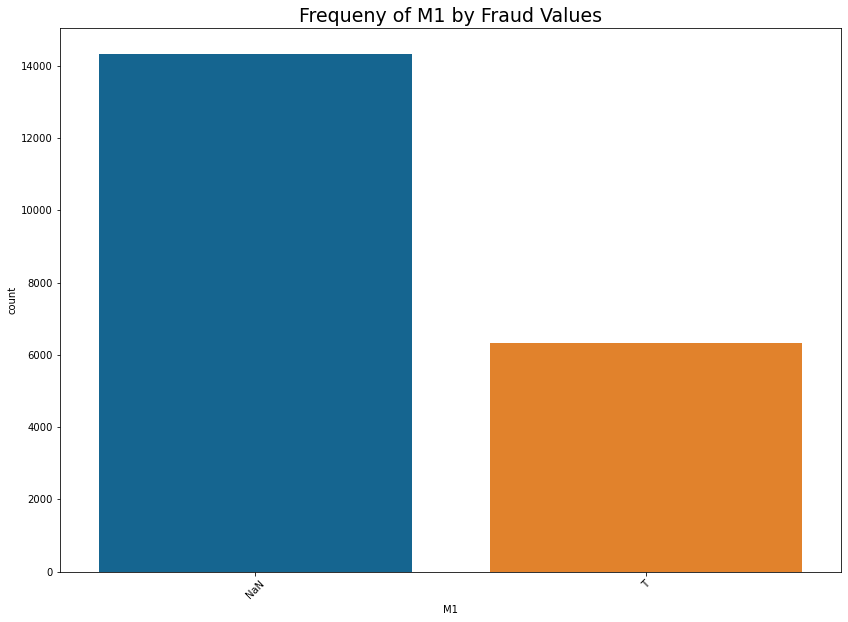

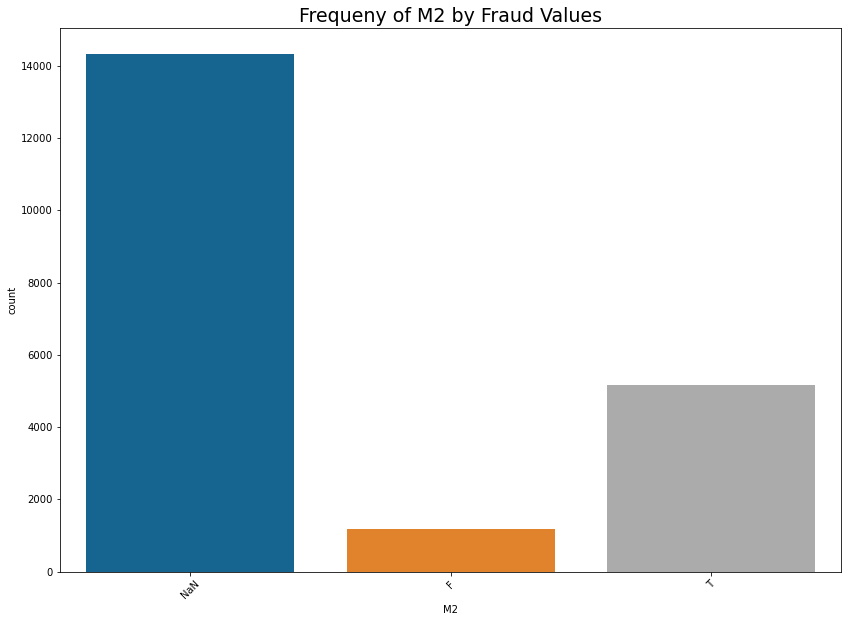

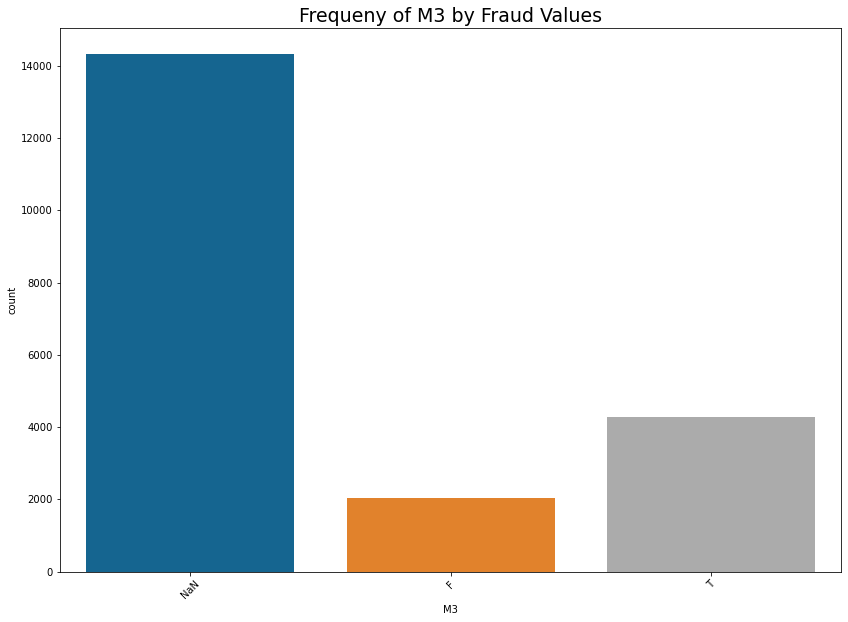

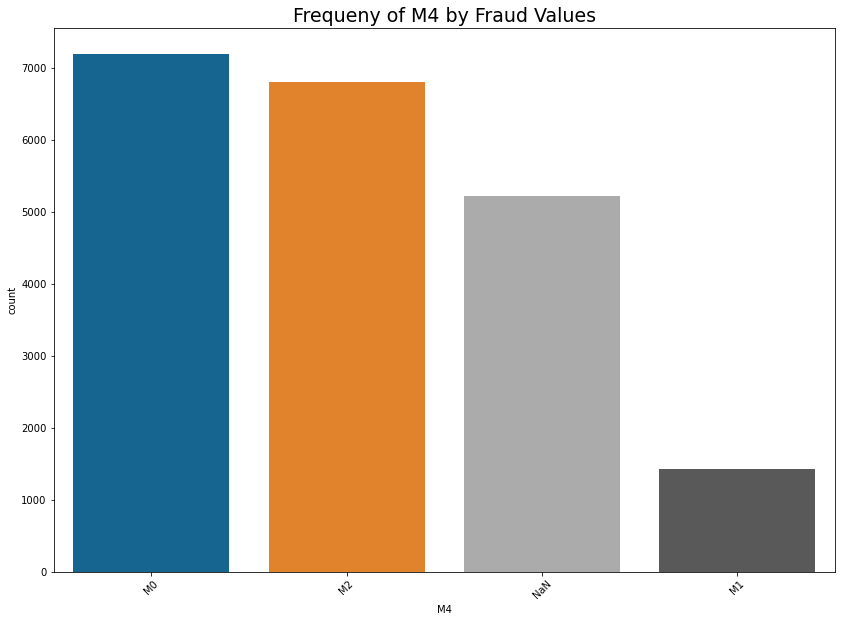

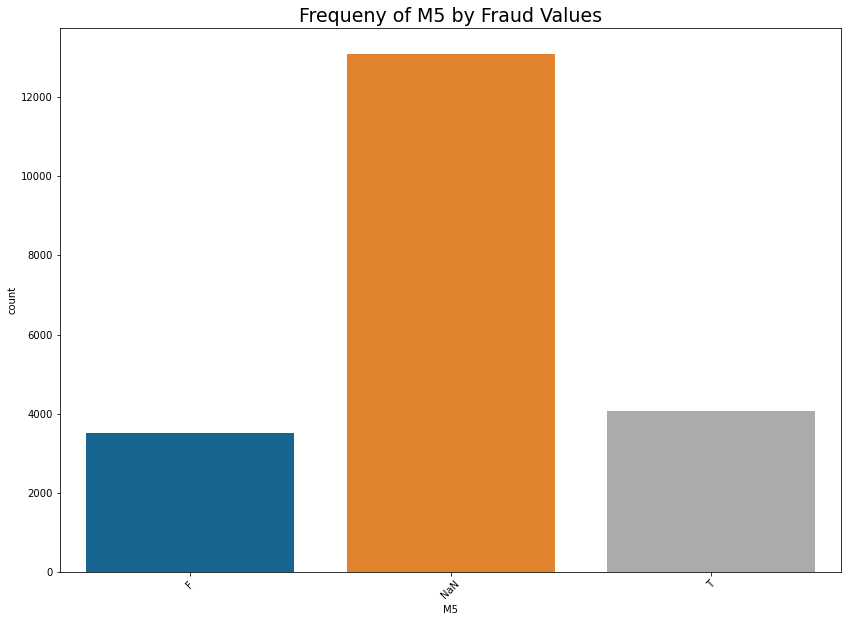

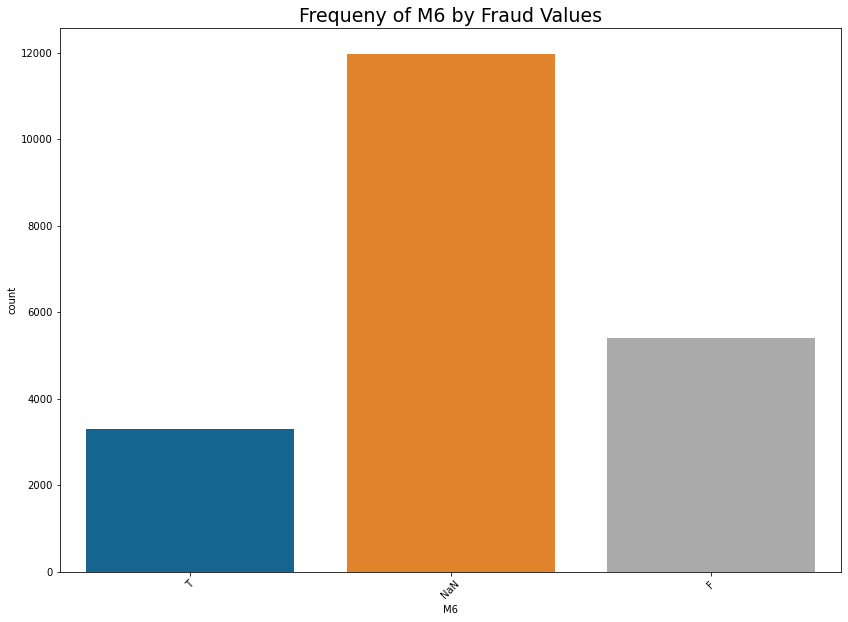

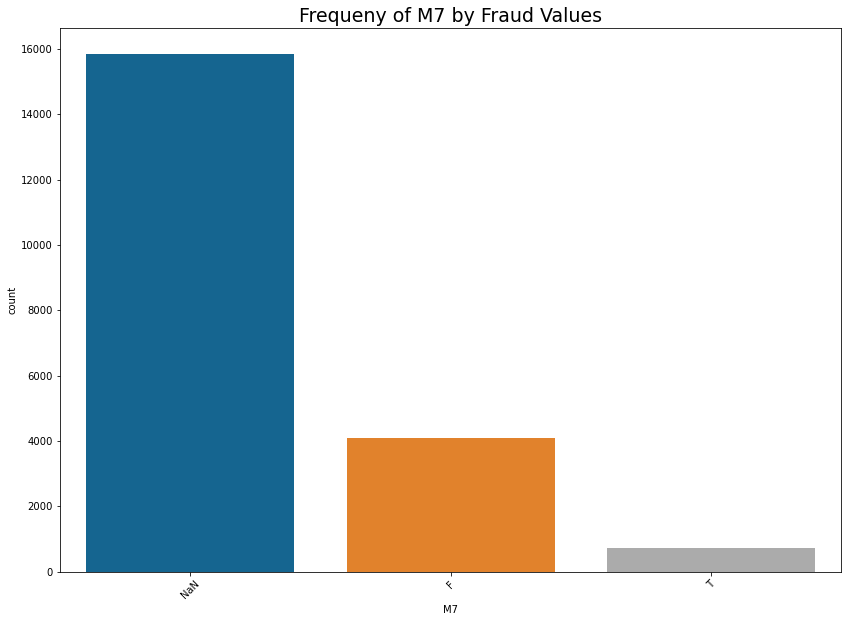

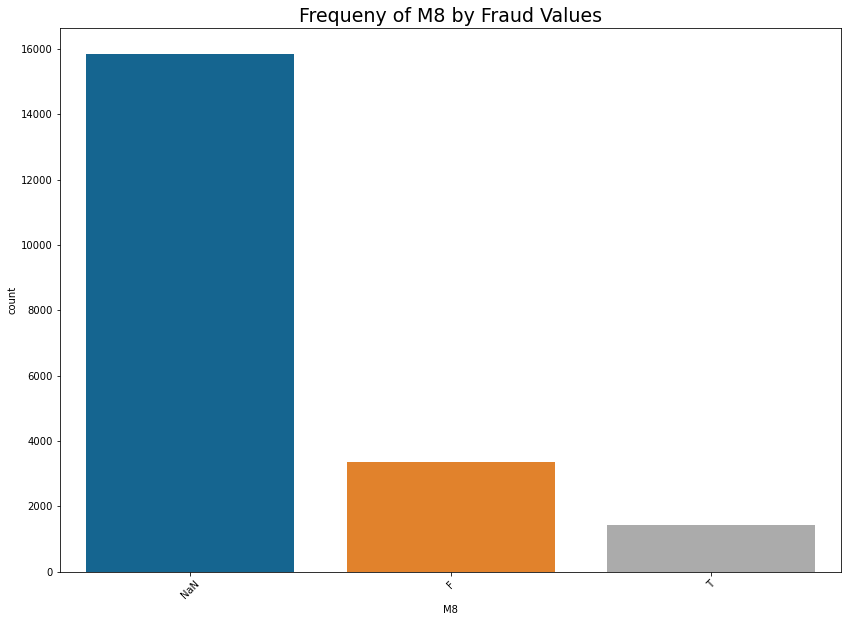

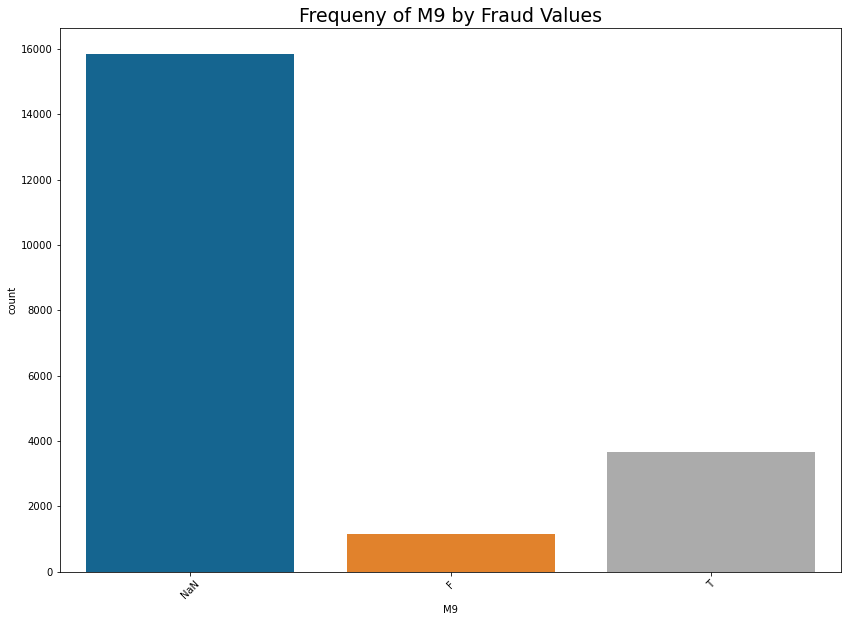

In [8]:
columns = M.columns

#df_trans = df_transaction.copy()

for col in columns:   
    
        
    df_trans = df_transaction[df_transaction.isFraud==1][col]  
    
    
    plt.figure(figsize=(14,10))
    
    g1 = sns.countplot(x=df_trans)
    
    g1.set_title("Frequeny of " + str(col)+ " by Fraud Values", fontsize=19)
 
    g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
    plt.show()
  
    del g1
    
    
    
    
del df_trans 


- High Frequency of Fraud values among 'M' variables which have missing values

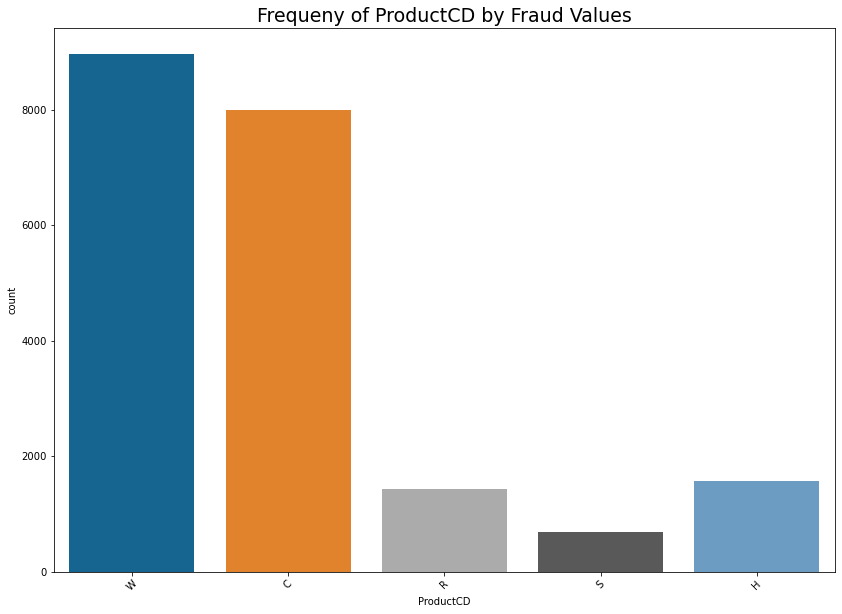

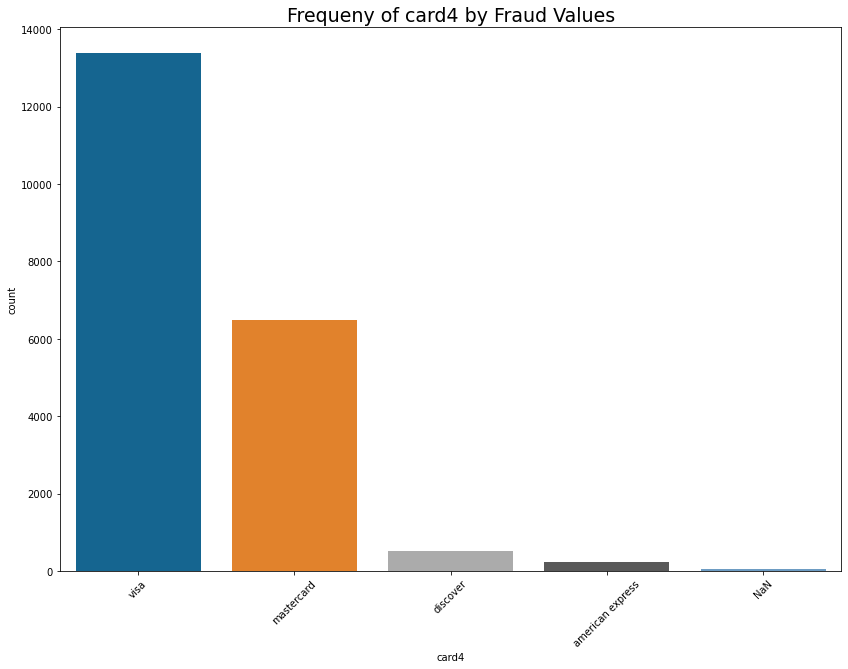

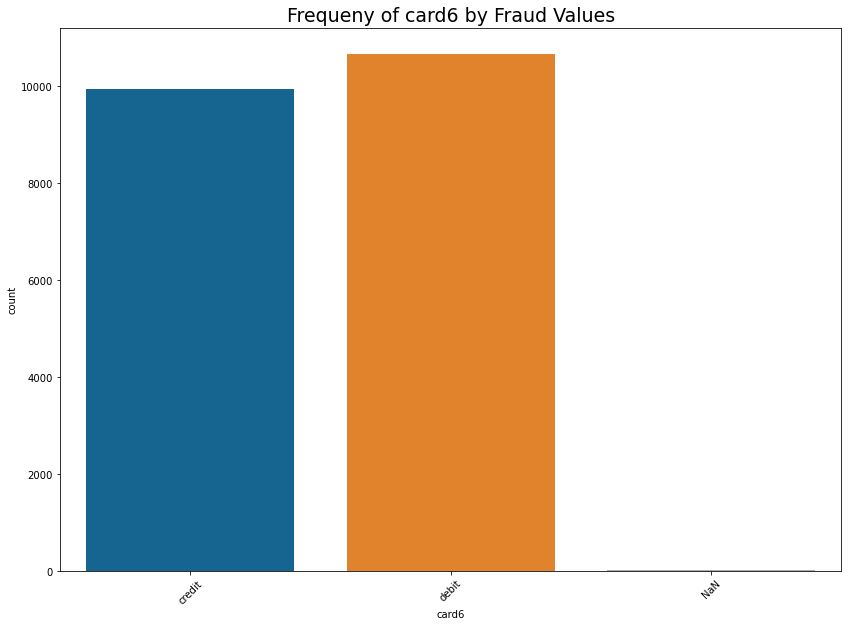

In [9]:
# Columns ProductCD, card4, card6
columns = ['ProductCD', 'card4', 'card6']

for col in columns:
    
    df_trans = df_transaction[df_transaction.isFraud==1][col]  
    
    
    plt.figure(figsize=(14,10))
    
    g1 = sns.countplot(x=df_trans)
    
    g1.set_title("Frequeny of " + str(col)+ " by Fraud Values", fontsize=19)
 
    g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
    plt.show()
  
    del g1

- Interesting Observations
  - High Frequency of Fraud in W in ProductCD
  - High Frequency of Fraud in visa
  - High Frequency of Fraud among debit cards

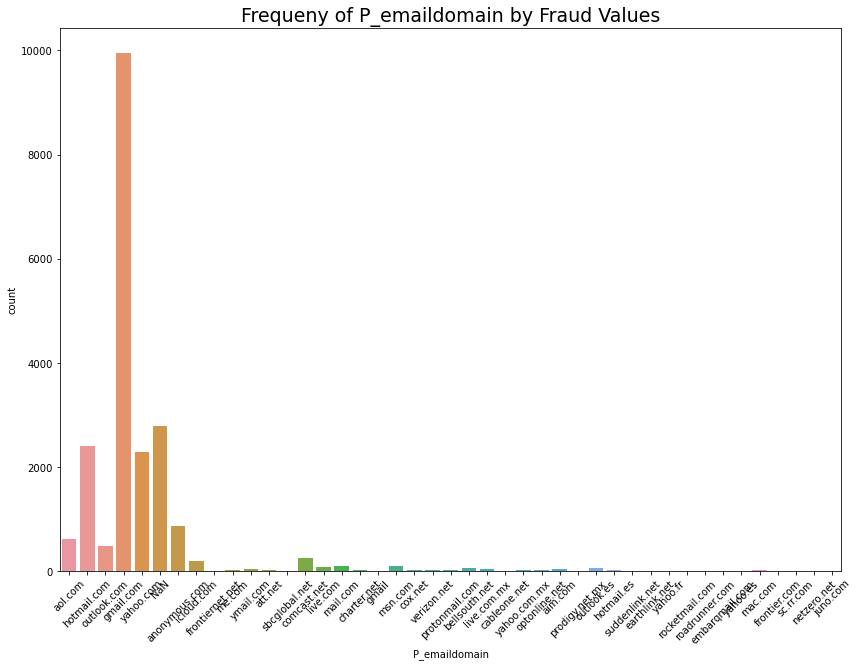

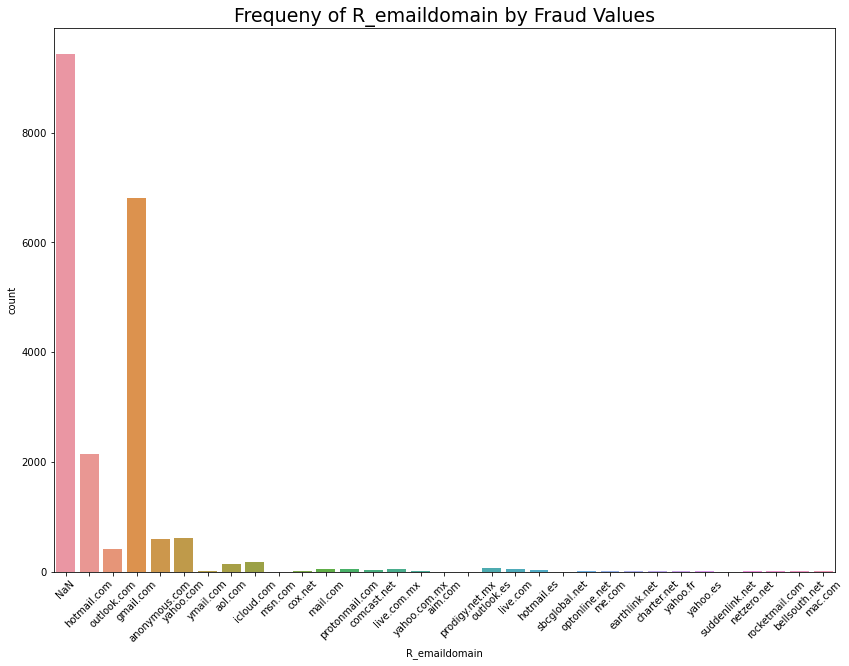

In [10]:
# Columns other than M
columns = ['P_emaildomain', 'R_emaildomain']


for col in columns:
    
    df_trans = df_transaction[df_transaction.isFraud==1][col]  
    
    
    plt.figure(figsize=(14,10))
    
    g1 = sns.countplot(x=df_trans)
    
    g1.set_title("Frequeny of " + str(col)+ " by Fraud Values", fontsize=19)
 
    g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
    plt.show()
  
    del g1
    

- Among P email domain, gmail.com has a high fraud frequency
- Among R email domain, gmail.com has a high fraud frequency

In [11]:
# Cramers V for categorical correlations
def cramers_v(x, y):
    x = np.array(x)
    y = np.array(y)
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))


cramersv = pd.DataFrame(index=data.columns,columns=data.columns)
columns = data.columns

for i in range(0,len(columns)):
    for j in range(0,len(columns)):
        #print(data[columns[i]].tolist())
        u = cramers_v(data[columns[i]].tolist(),data[columns[j]].tolist())
        cramersv.loc[columns[i],columns[j]] = u
        
cramersv.fillna(value=np.nan,inplace=True)

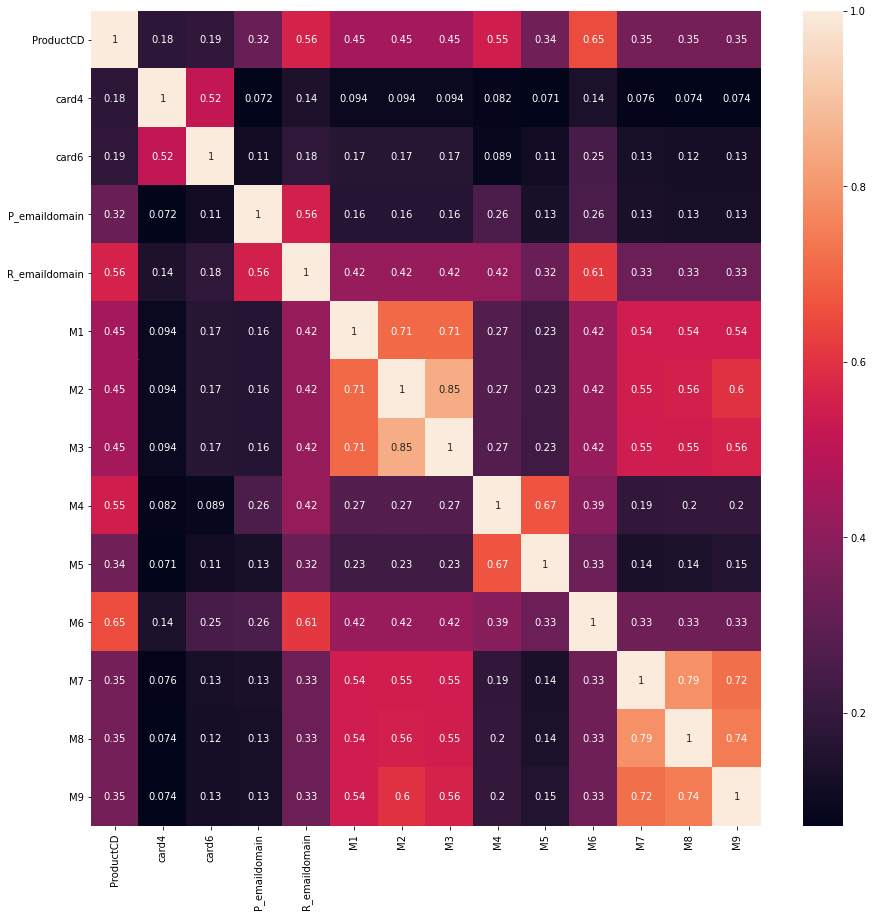

In [12]:
plt.figure(figsize=(15,15))
sns.heatmap(cramersv, annot=True)
plt.show()

In [13]:
# Reduce Memory
del cramersv,data

- Columns M2 and M3 have a very strong correlation of 0.85.
- Also from the line plots M2 and M3 share a similar pattern of fraud correlation


## Non Categorical Columns

In [14]:
df_transaction.drop(columns=M.columns,inplace=True)
print(df_transaction.head(10))
del M

   TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   
5        2987005        0          86510            49.0         W   5937   
6        2987006        0          86522           159.0         W  12308   
7        2987007        0          86529           422.5         W  12695   
8        2987008        0          86535            15.0         H   2803   
9        2987009        0          86536           117.0         W  17399   

  card2 card3       card4 card5  ... V330 V331 V332 V333 V334 V335 V336  V337  \
0   NaN   150    discover   142  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN

In [15]:
print(df_transaction.columns)

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
       'V339'],
      dtype='object', length=385)


In [16]:
# Too many V variables. We can do a correlation analysis and remove columns that are highly correlated
V = df_transaction.filter(regex='^V',axis=1)

print(len(V))

590540


- Drop V columns which have high correlation

In [17]:
# Create correlation matrix

V = V.applymap(float)
corr_matrix = V.corr().abs()


# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

print(to_drop)
HighCorrVDrop = to_drop

del corr_matrix, upper

['V11', 'V16', 'V18', 'V21', 'V22', 'V28', 'V30', 'V32', 'V33', 'V34', 'V43', 'V49', 'V50', 'V52', 'V57', 'V58', 'V60', 'V63', 'V70', 'V71', 'V72', 'V74', 'V81', 'V84', 'V89', 'V91', 'V92', 'V93', 'V94', 'V97', 'V101', 'V102', 'V103', 'V106', 'V126', 'V127', 'V128', 'V132', 'V133', 'V134', 'V143', 'V145', 'V149', 'V150', 'V151', 'V153', 'V154', 'V155', 'V156', 'V158', 'V159', 'V160', 'V163', 'V164', 'V167', 'V168', 'V177', 'V178', 'V179', 'V182', 'V192', 'V193', 'V196', 'V199', 'V202', 'V204', 'V206', 'V211', 'V212', 'V213', 'V217', 'V219', 'V222', 'V225', 'V231', 'V232', 'V233', 'V236', 'V237', 'V244', 'V249', 'V251', 'V253', 'V254', 'V256', 'V263', 'V265', 'V266', 'V269', 'V272', 'V273', 'V275', 'V276', 'V277', 'V278', 'V279', 'V280', 'V292', 'V293', 'V294', 'V295', 'V296', 'V298', 'V299', 'V304', 'V306', 'V307', 'V308', 'V311', 'V316', 'V317', 'V318', 'V322', 'V323', 'V324', 'V326', 'V327', 'V328', 'V329', 'V330', 'V331', 'V332', 'V333', 'V334']


In [18]:
# Let's look at other columns
df_transaction.drop(columns = V.columns,inplace=True)
del V

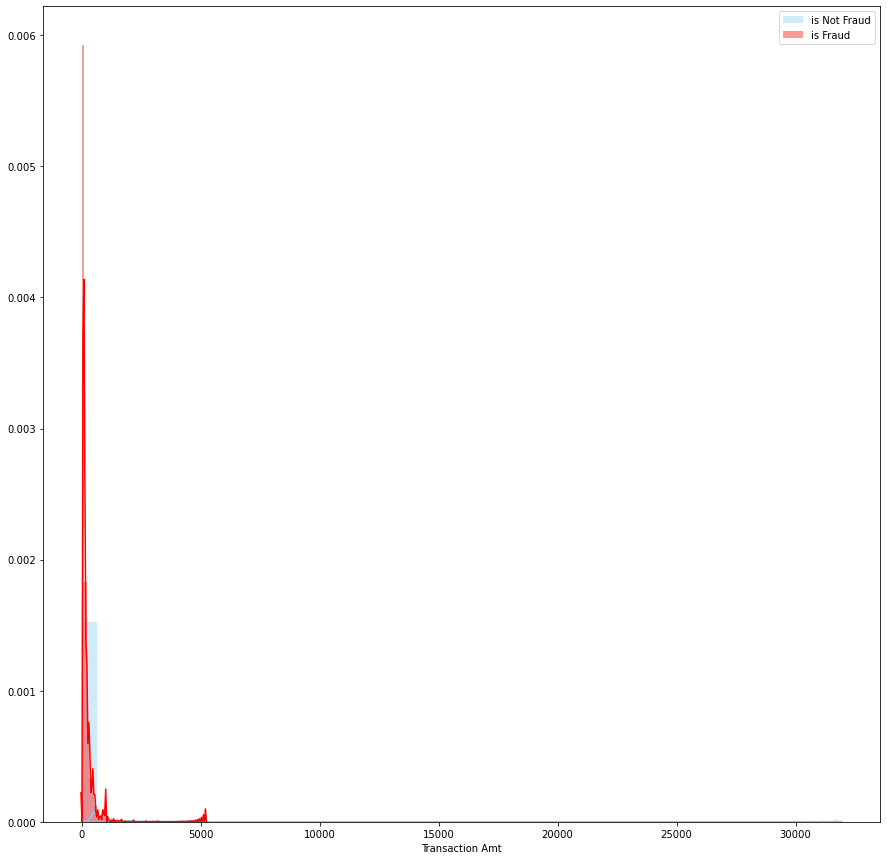

In [19]:
# Let's look at transaction amt

df_transaction['TransactionAmt'] = df_transaction['TransactionAmt'].apply(pd.to_numeric)
f, ax = plt.subplots(1, 1,figsize=(15,15))

sns.distplot(ax= ax,a = df_transaction[df_transaction['isFraud']==0]['TransactionAmt'], color="skyblue", label="is Not Fraud")


sns.distplot(ax=ax,a = df_transaction[df_transaction['isFraud']==1]['TransactionAmt'], color="red", label="is Fraud")
plt.legend(labels=['is Not Fraud', 'is Fraud'])
ax.set_xlabel("Transaction Amt")

plt.show()



- Applying log transformation on data

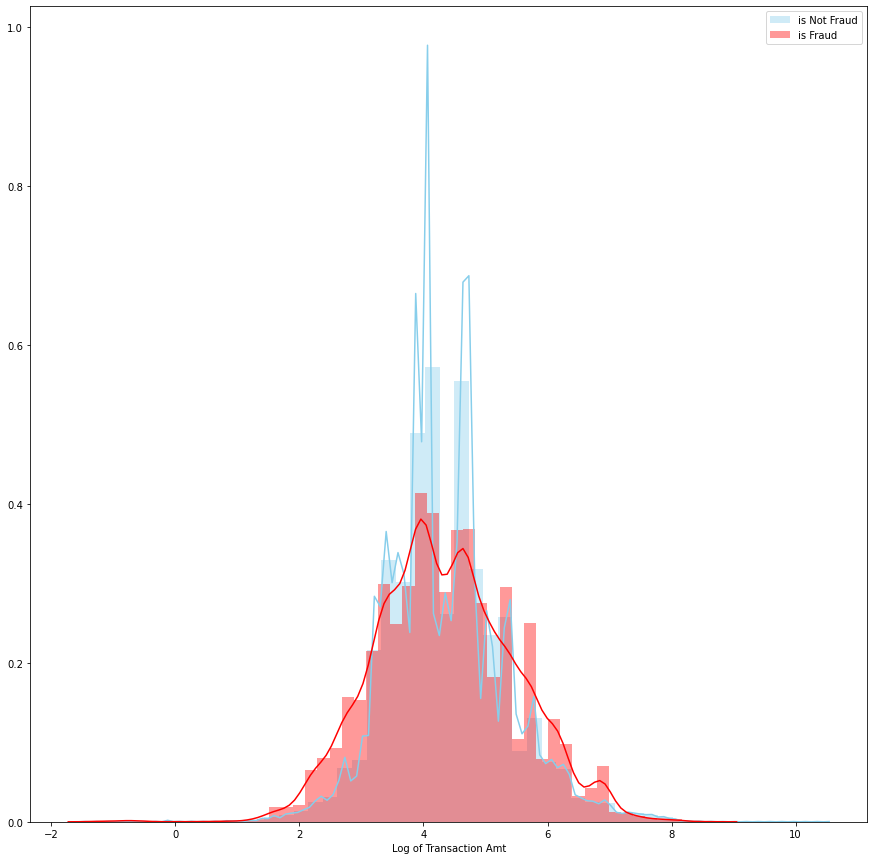

In [20]:
# Data heavily skewed. Apply log of the data

f, ax = plt.subplots(1, 1,figsize=(15,15))

sns.distplot(ax= ax,a = np.log(df_transaction[df_transaction['isFraud']==0]['TransactionAmt']), color="skyblue", label="is Not Fraud")


sns.distplot(ax=ax,a = np.log(df_transaction[df_transaction['isFraud']==1]['TransactionAmt']), color="red", label="is Fraud")
plt.legend(labels=['is Not Fraud', 'is Fraud'])
ax.set_xlabel("Log of Transaction Amt")
plt.show()

- It would be better if we scale the values of the transaction amount while training

- C subset columns
- Due to high presence of many features. Let's pick only the top features by frquency for plotting

In [21]:
# Find which of the columns have the highest frquency among fake transactions

df_trans = df_transaction[df_transaction['isFraud']==1]
df_tran = df_transaction.copy()
C = df_transaction.filter(regex='^C',axis=1)



for col in C.columns:
   
    index_list = df_trans[col].value_counts(ascending=False)[:15].index.to_list()
    df_tran.loc[df_tran[(~df_tran[col].isin(index_list))].index, col] = "Others"
    
    
del df_trans

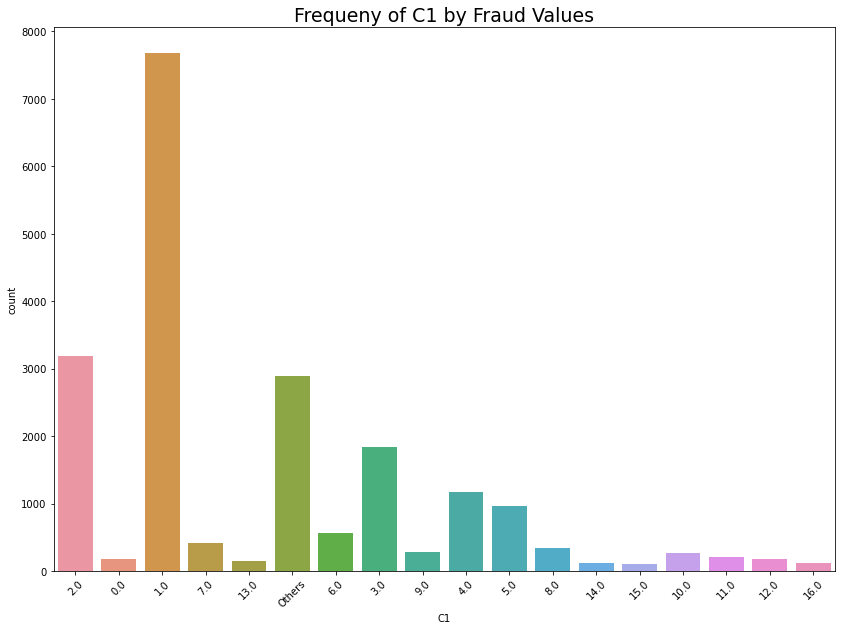

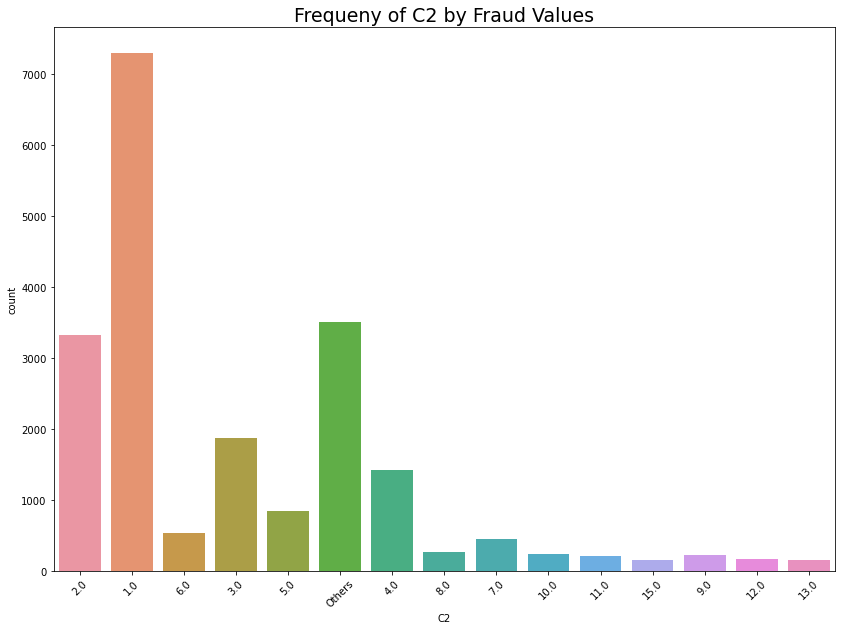

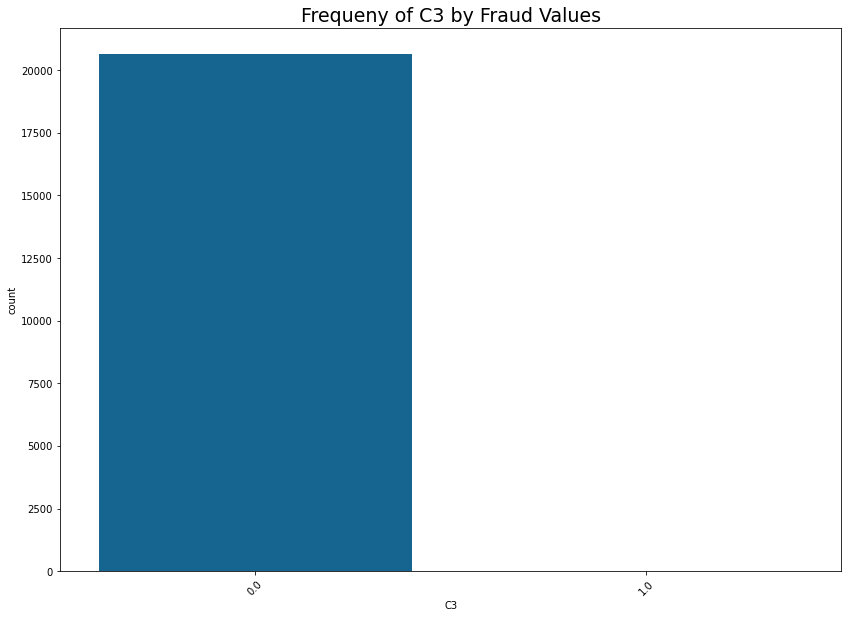

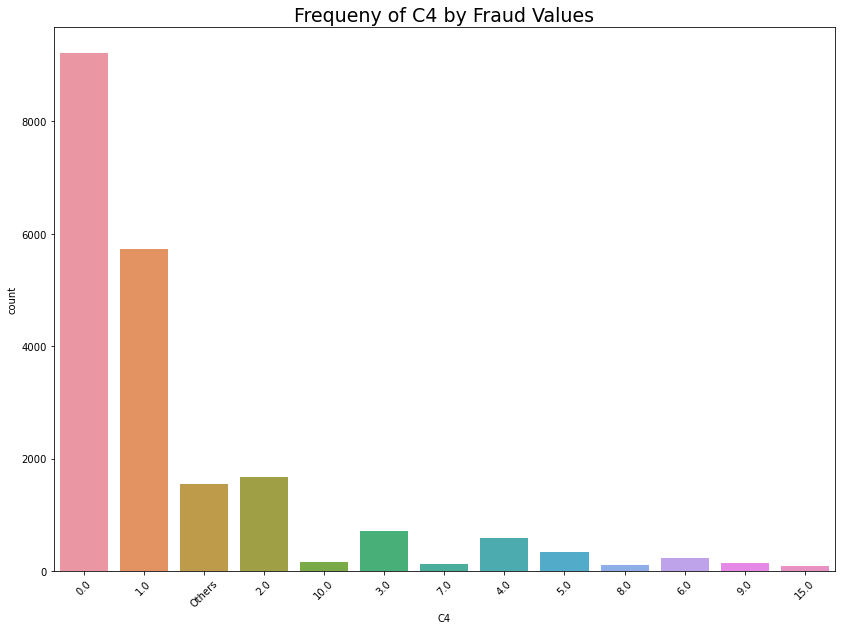

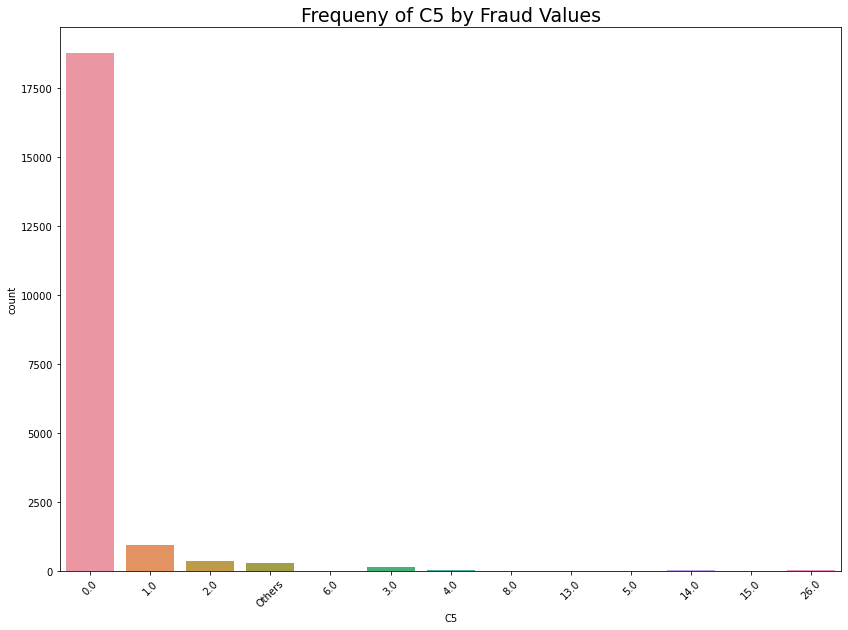

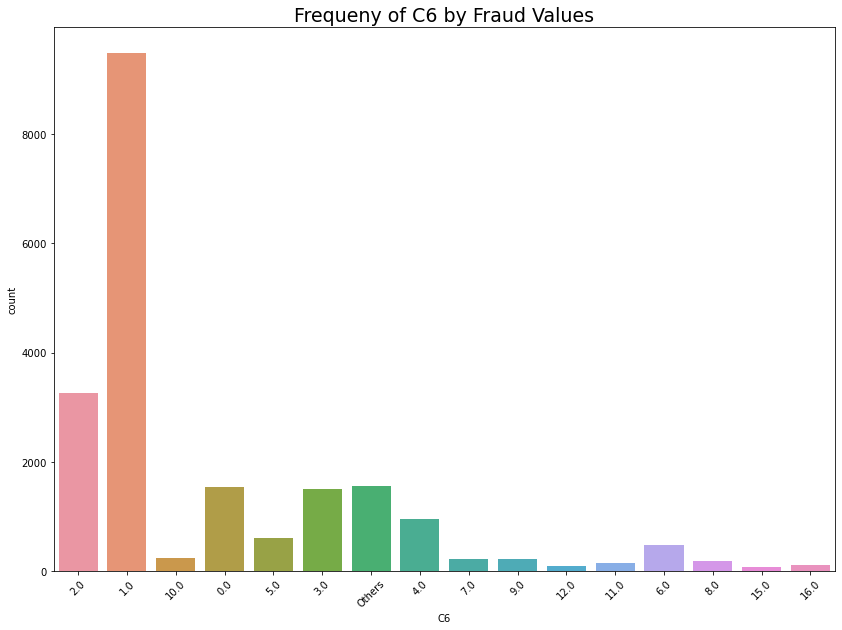

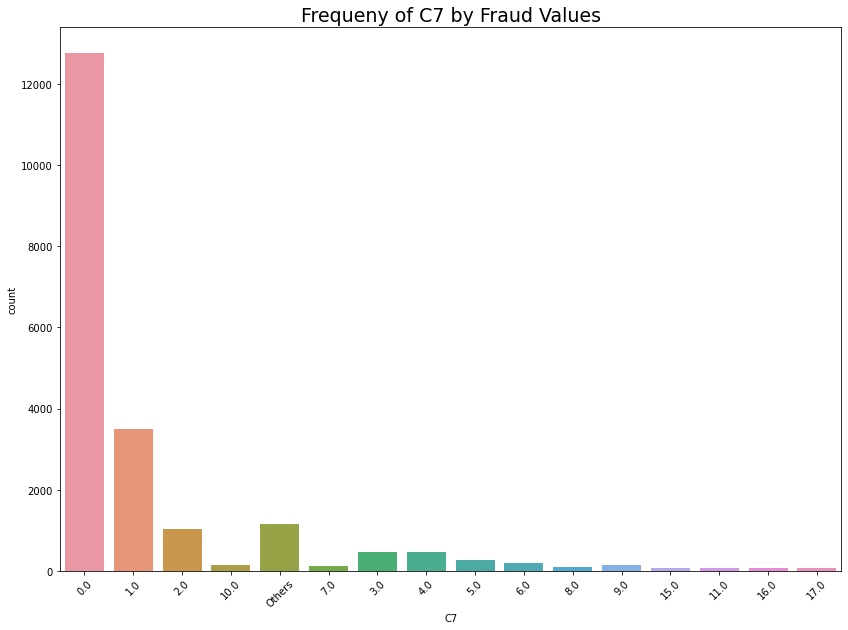

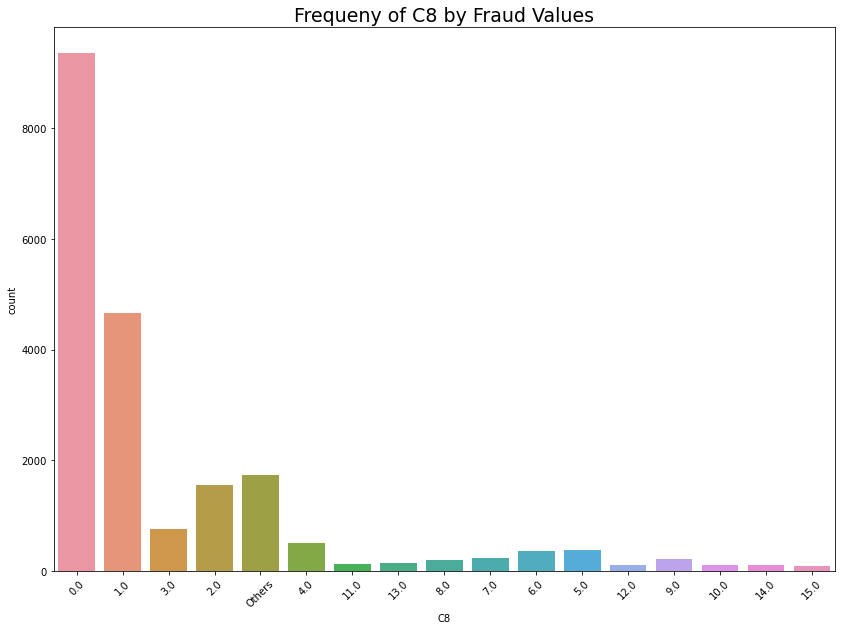

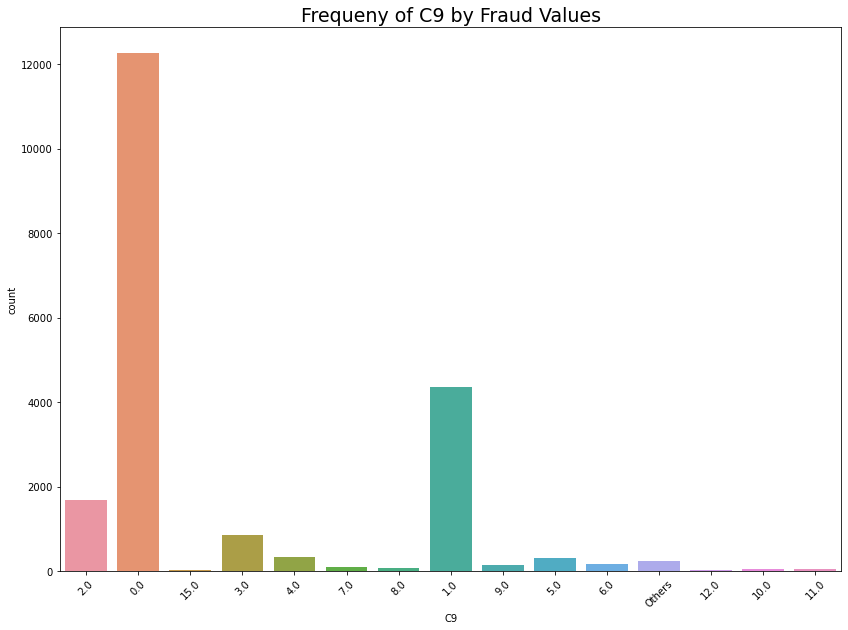

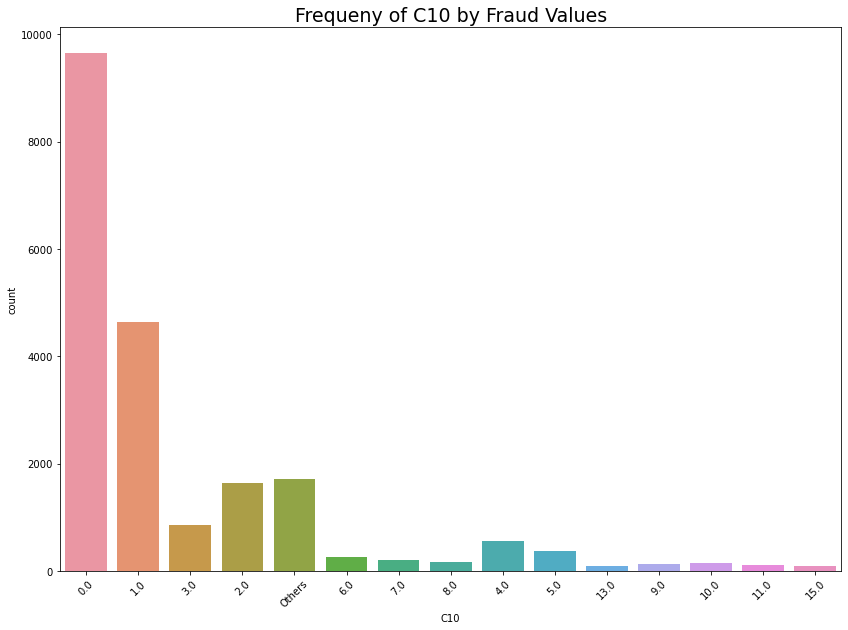

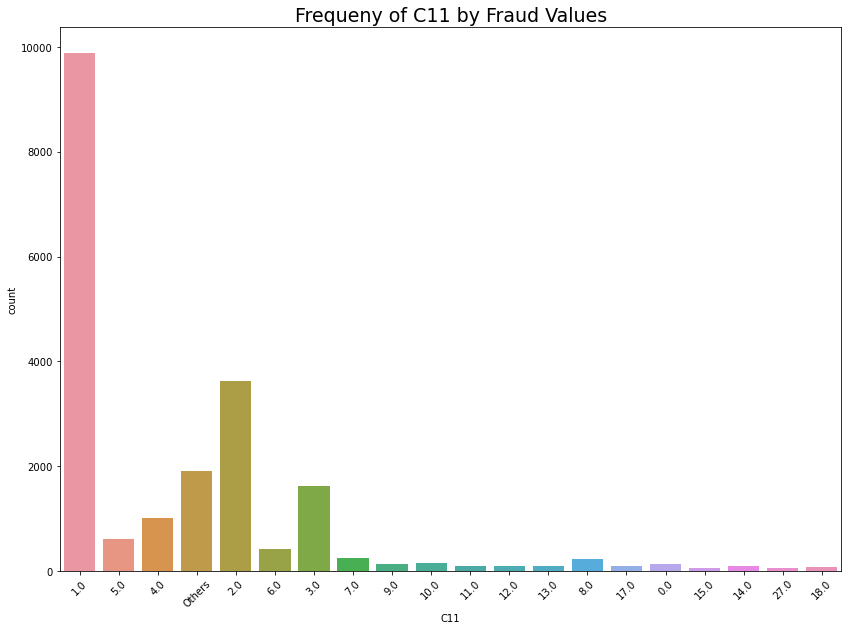

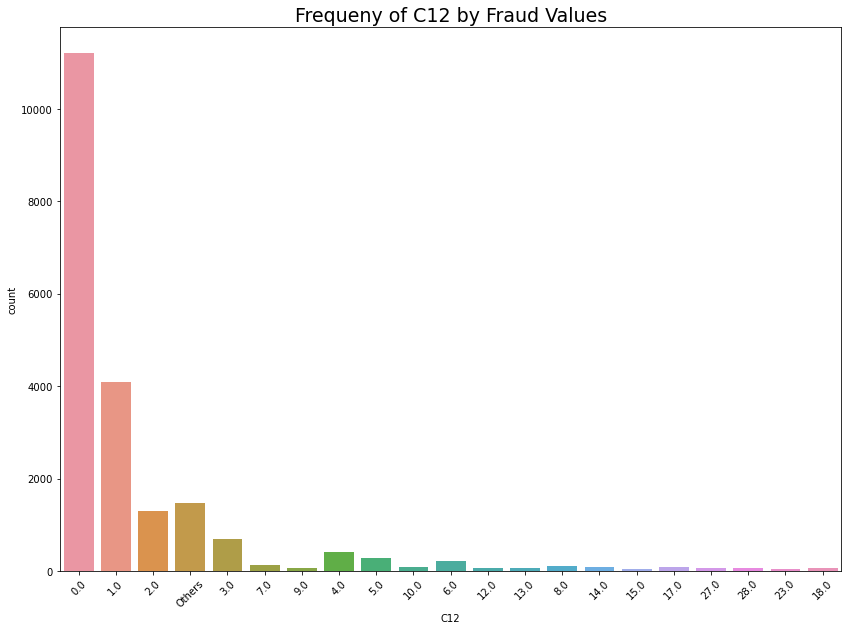

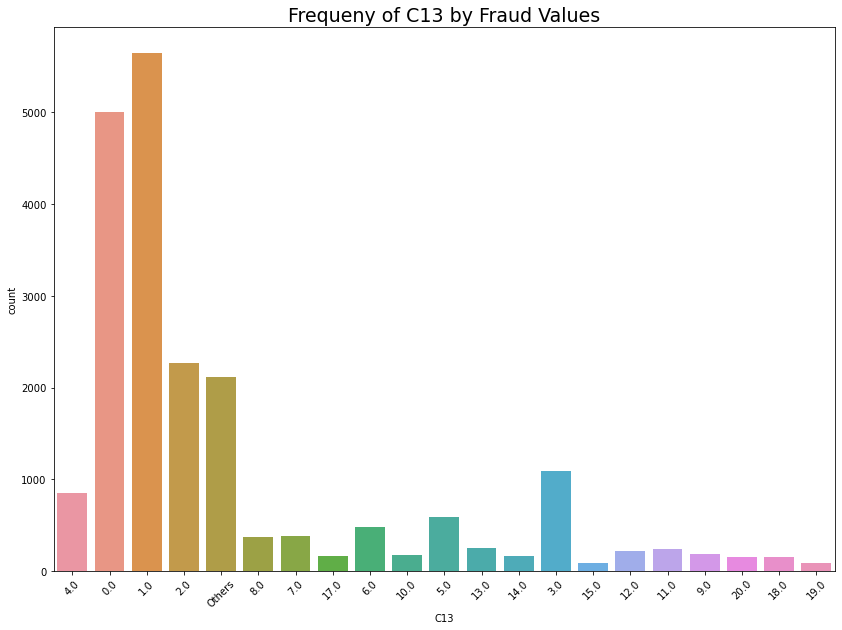

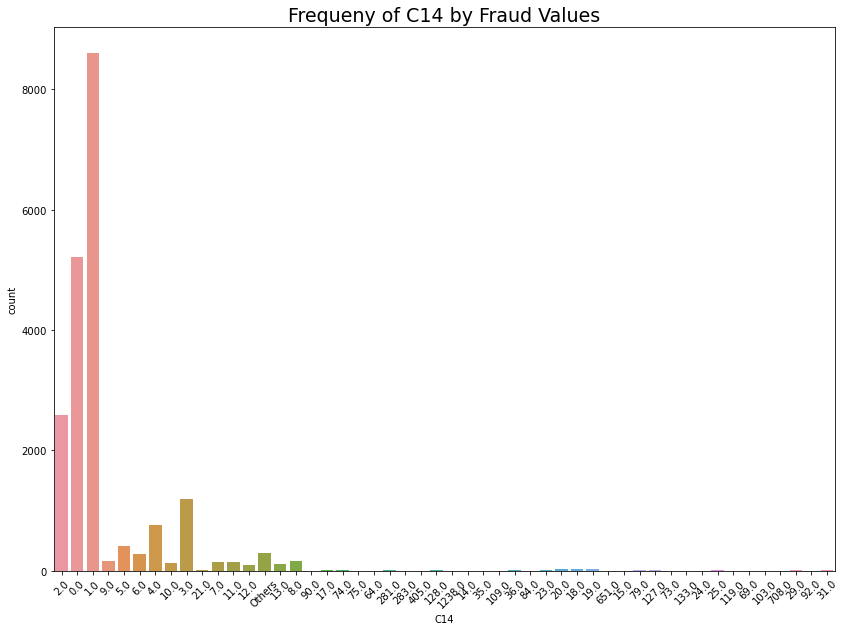

In [22]:
columns = C.columns


for col in columns:
    
    df_trans = df_tran[df_tran.isFraud==1][col]  
    
    
    plt.figure(figsize=(14,10))
    
    g1 = sns.countplot(x=df_trans)
    
    g1.set_title("Frequeny of " + str(col)+ " by Fraud Values", fontsize=19)
 
    g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
    plt.show()
  
    del g1
    
del C

- Some interesting Features from the graphs regarding the fraud for various features. Now let's look at D i.e days between transactions
  

In [23]:
# Find which of the columns have the highest frquency among fake transactions
# Due to high presence of many features. Let's pick only the top features by frequency for plotting

df_trans = df_transaction[df_transaction['isFraud']==1]
df_tran = df_transaction.copy()
D = df_transaction.filter(regex='^D',axis=1)



for col in D.columns:
   
    index_list = df_trans[col].value_counts(ascending=False)[:15].index.to_list()
    df_tran.loc[df_tran[(~df_tran[col].isin(index_list))].index, col] = "Others"
    
    
del df_trans

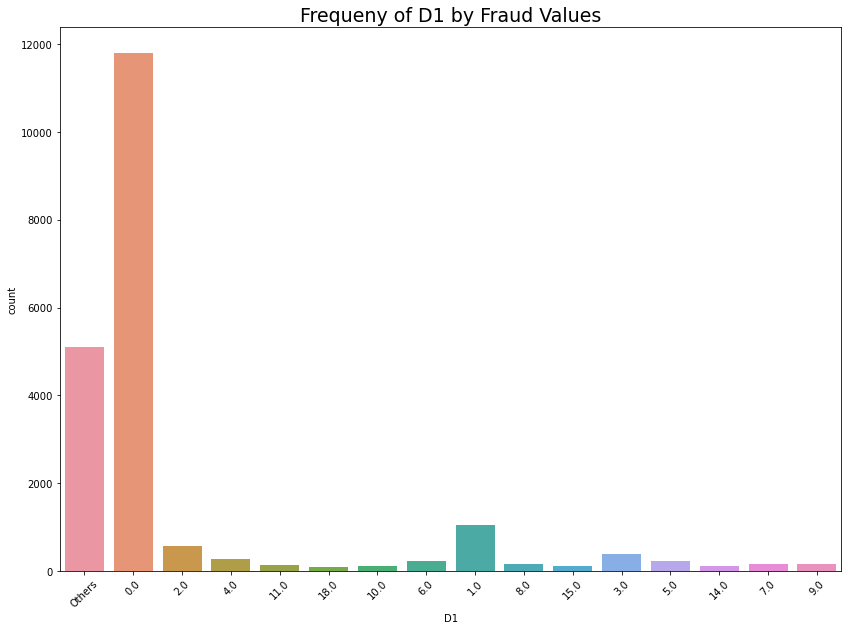

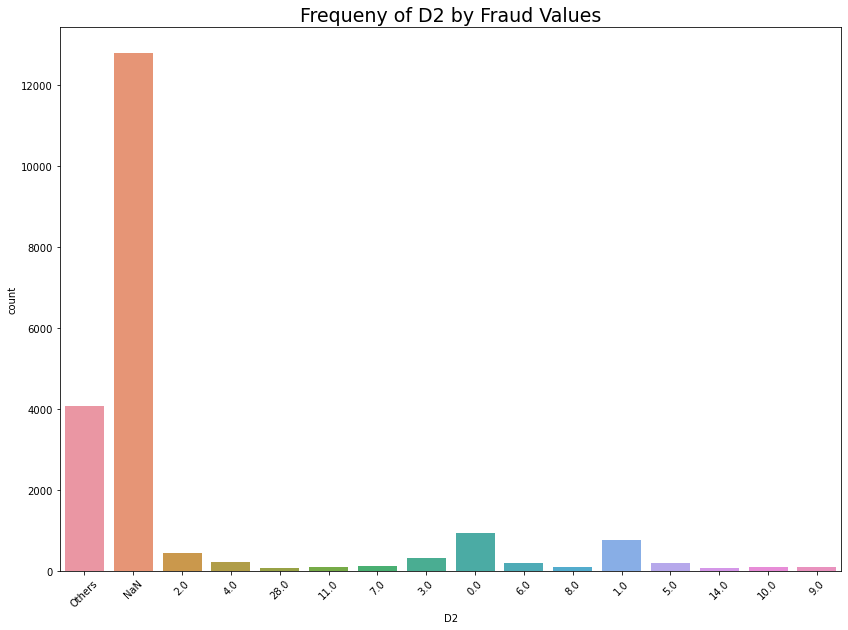

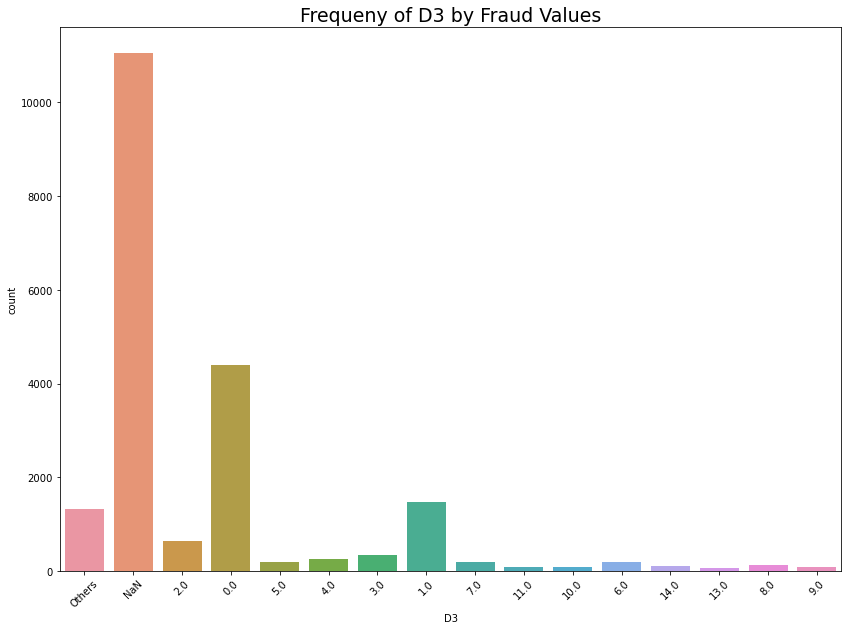

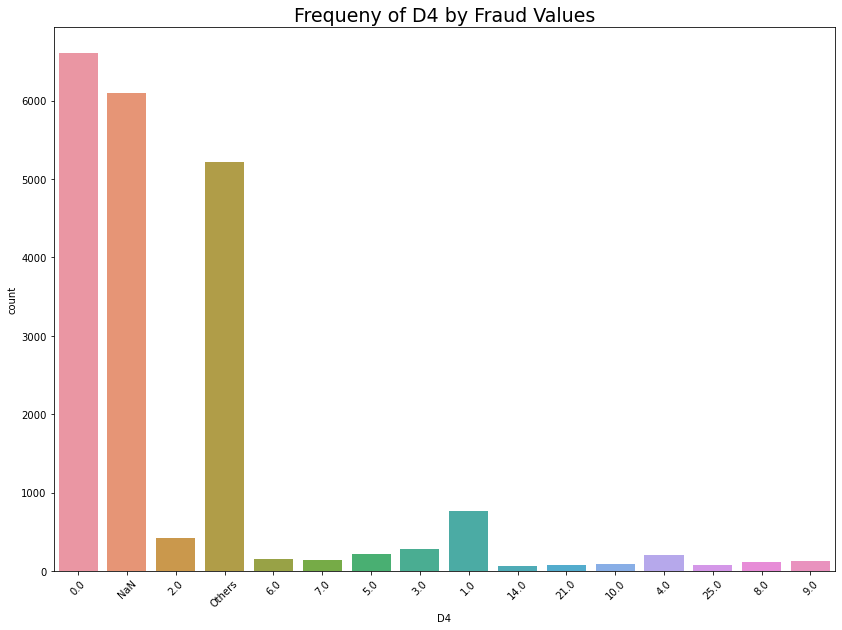

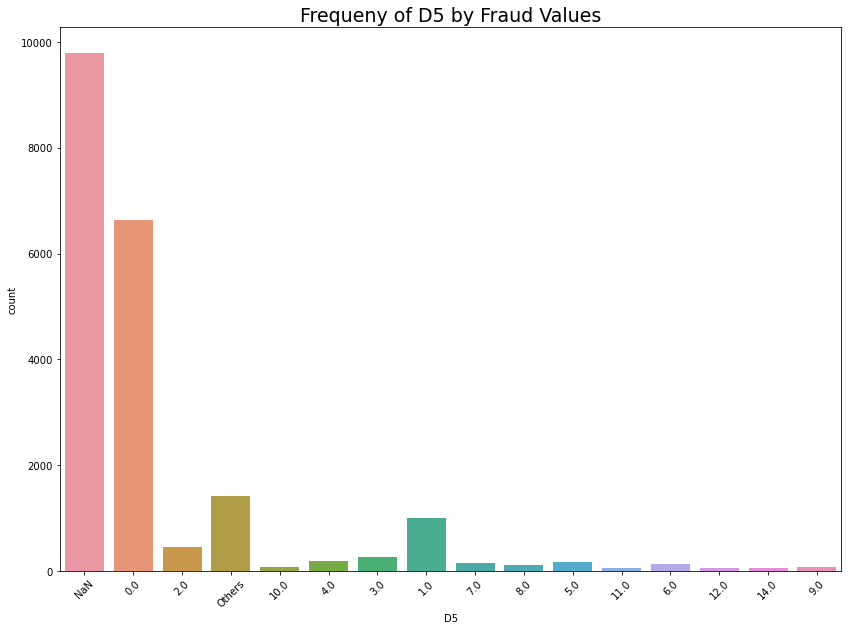

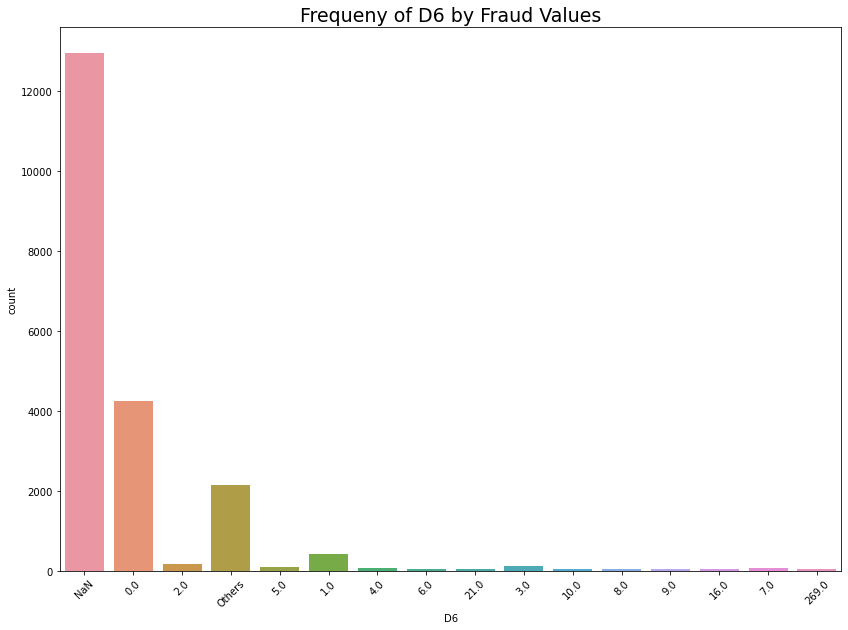

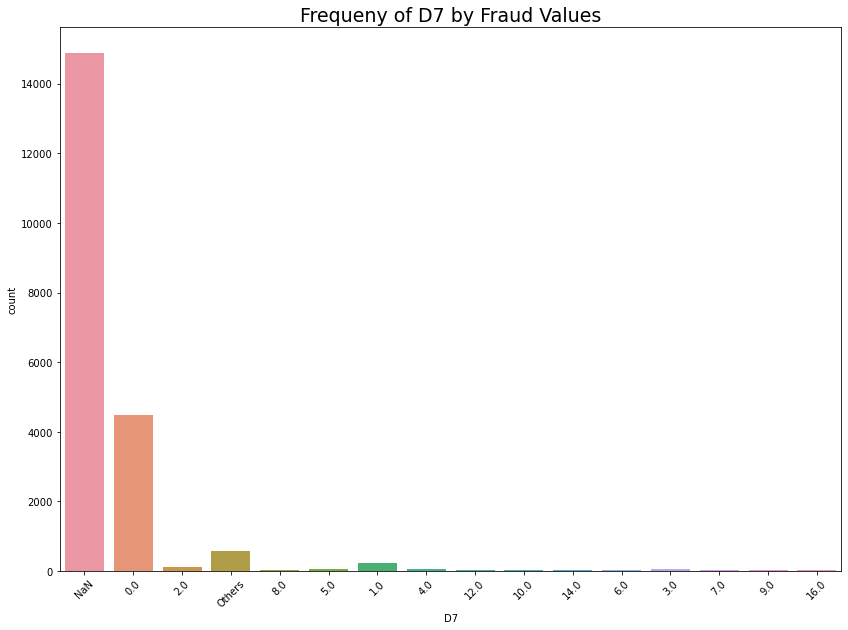

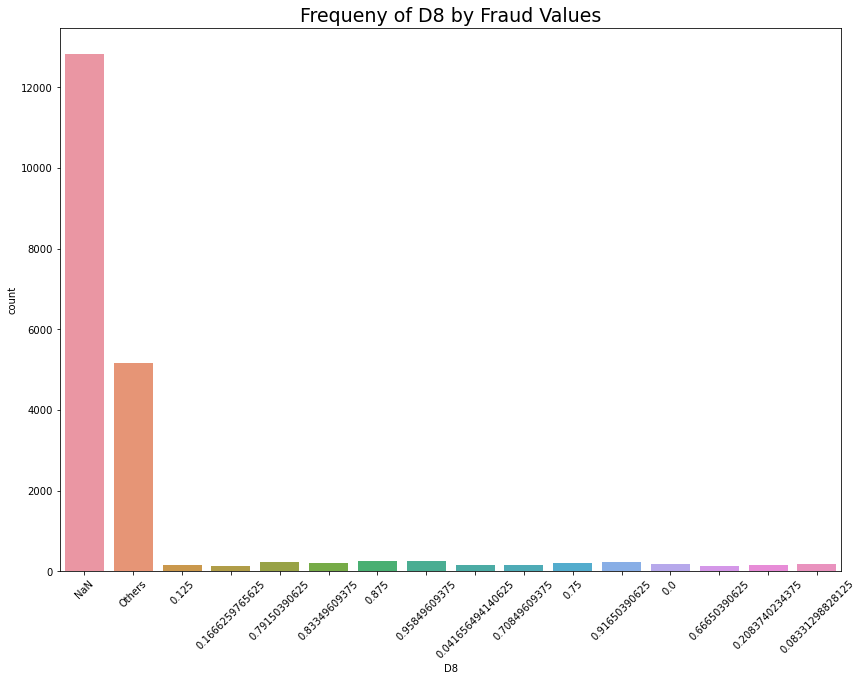

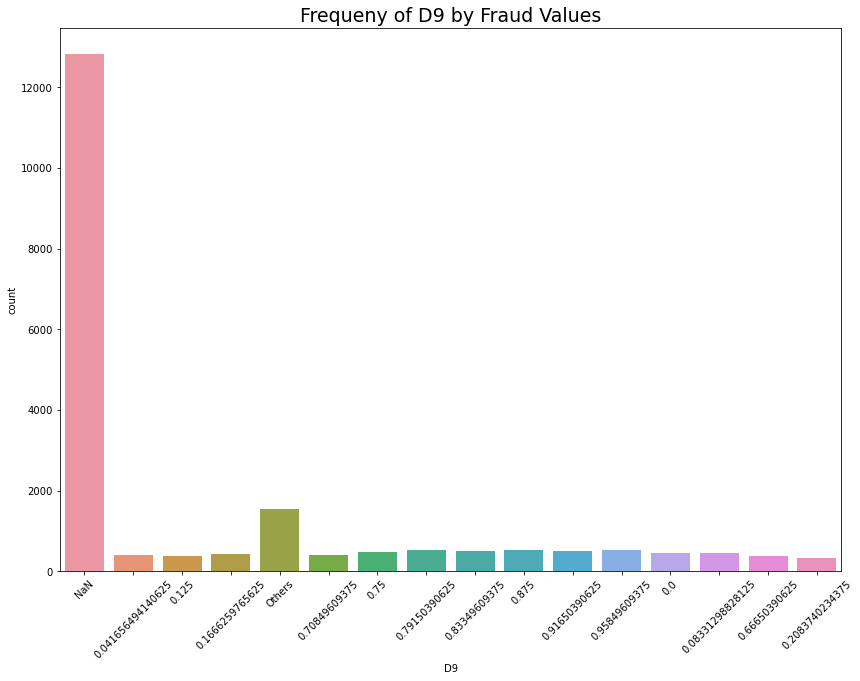

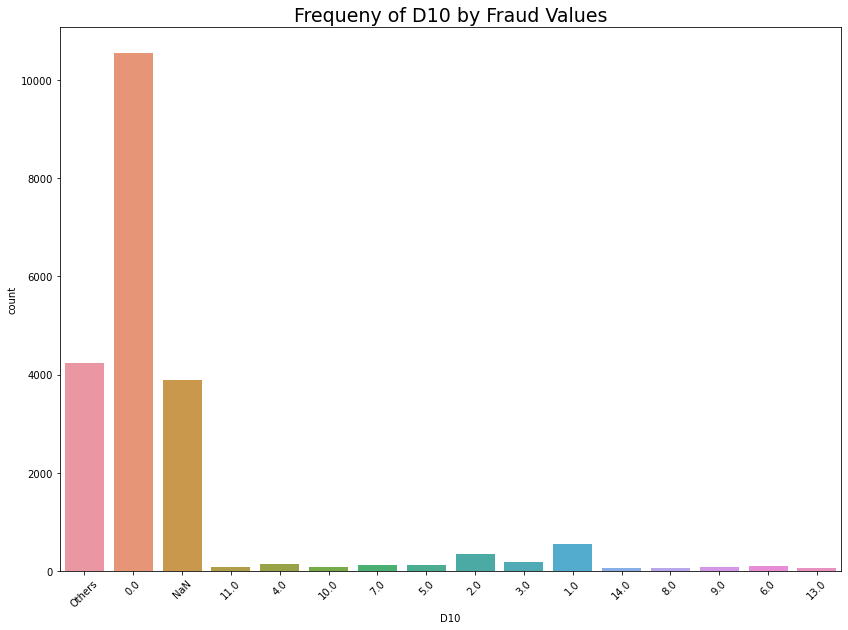

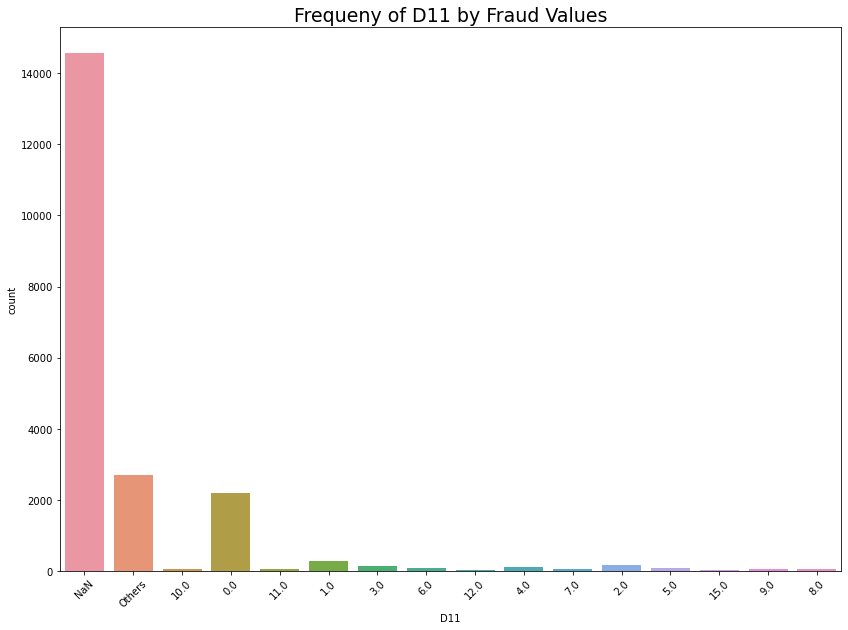

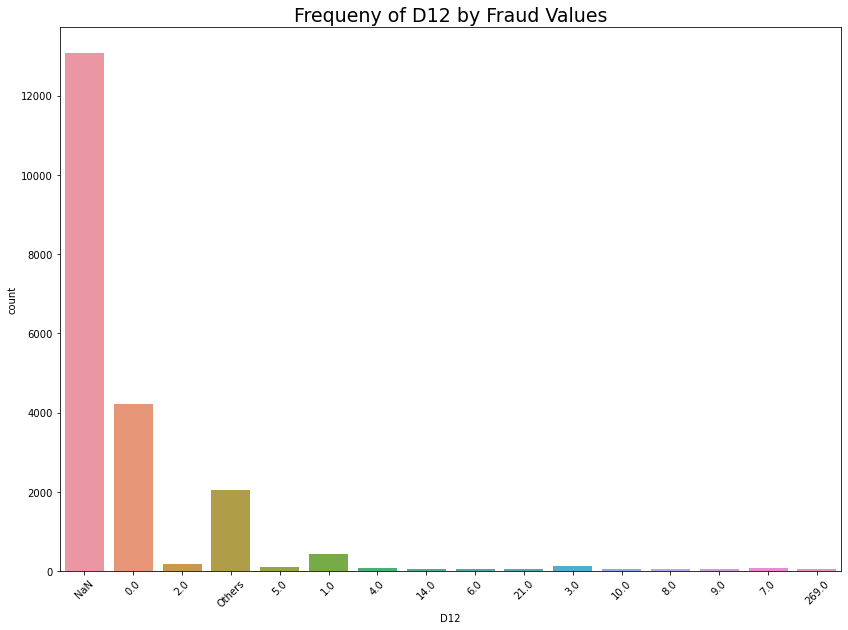

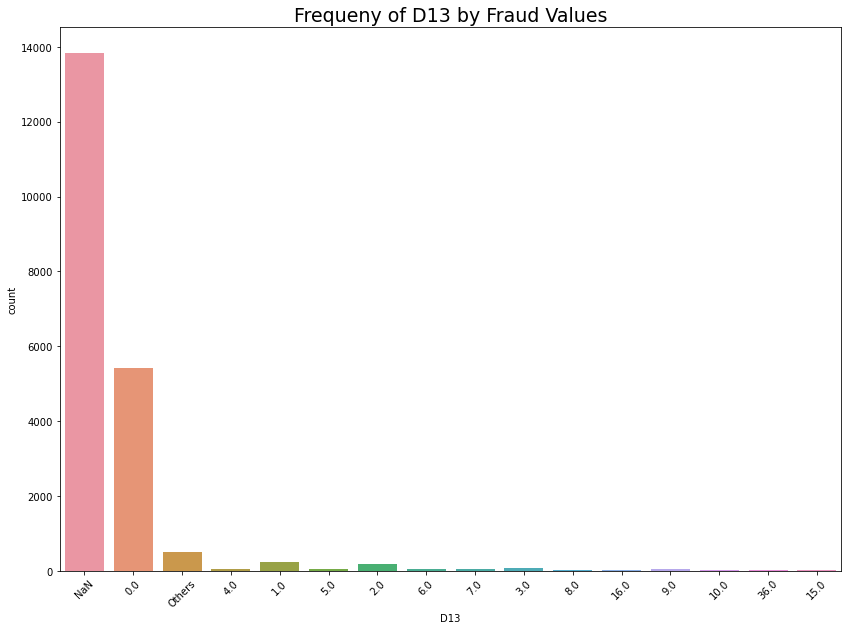

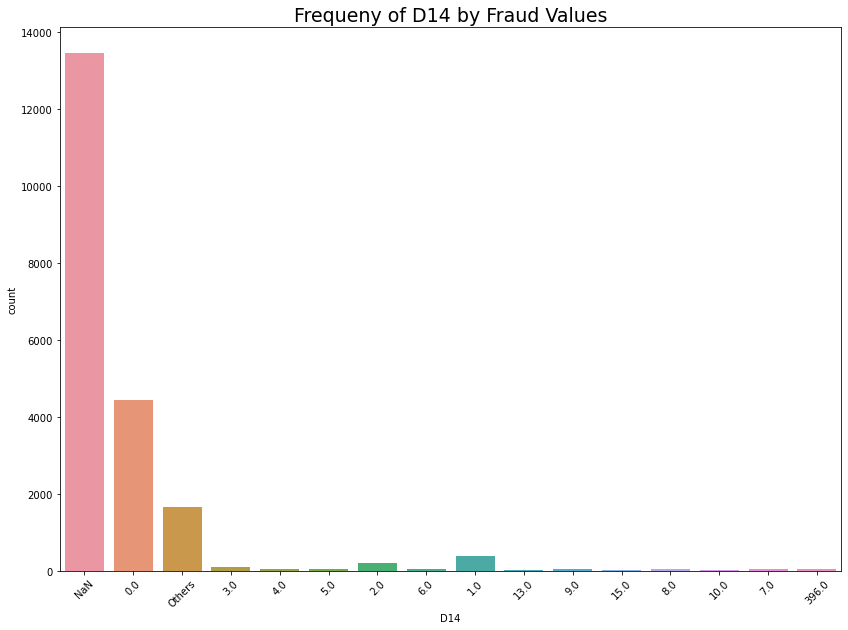

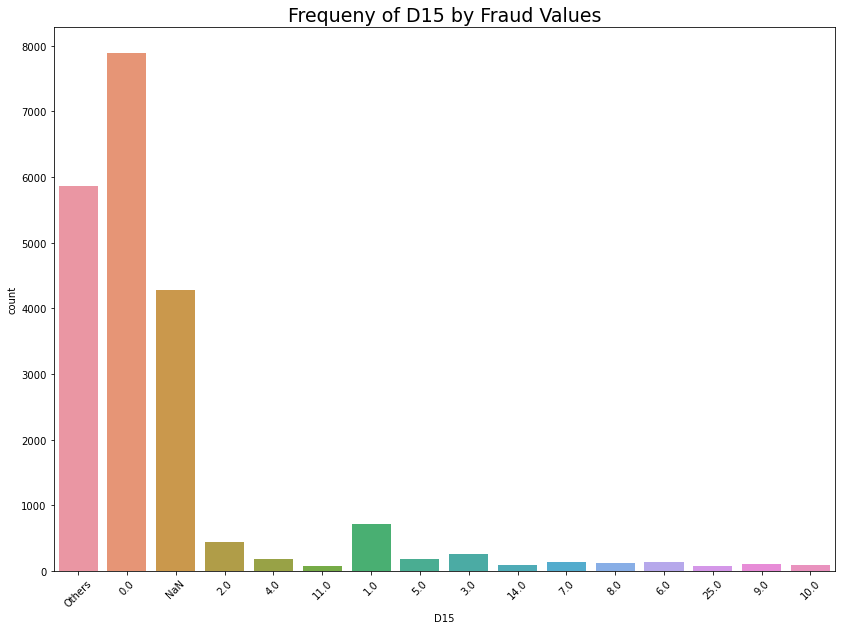

In [24]:
columns = D.columns


for col in columns:
    
    df_trans = df_tran[df_tran.isFraud==1][col]  
    
    
    plt.figure(figsize=(14,10))
    
    g1 = sns.countplot(x=df_trans)
    
    g1.set_title("Frequeny of " + str(col)+ " by Fraud Values", fontsize=19)
 
    g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
    plt.show()
  
    del g1
    
del D


- Not sure of the meaning between the different TimeDelta's, but there seems to be a high frequency for NaN values

- Distance and address columns

In [25]:
# Find which of the columns have the highest frquency among fake transactions
# Due to high presence of many features. Let's pick only the top features by frquency for plotting

df_trans = df_transaction[df_transaction['isFraud']==1]
df_tran = df_transaction.copy()
D = df_transaction[['addr1','addr2','dist1','dist2']]



for col in D.columns:
   
    index_list = df_trans[col].value_counts(ascending=False)[:15].index.to_list()
    df_tran.loc[df_tran[(~df_tran[col].isin(index_list))].index, col] = "Others"
    
    
del df_trans

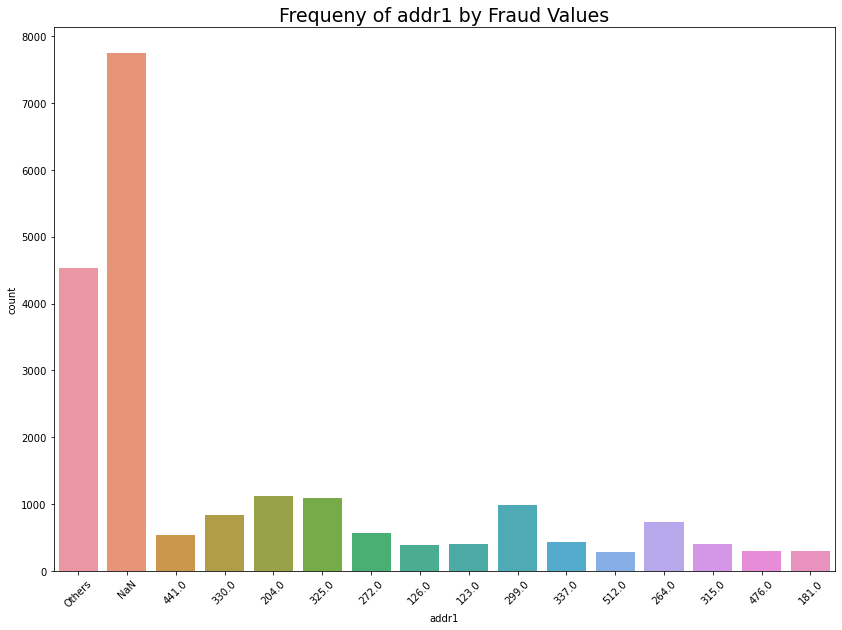

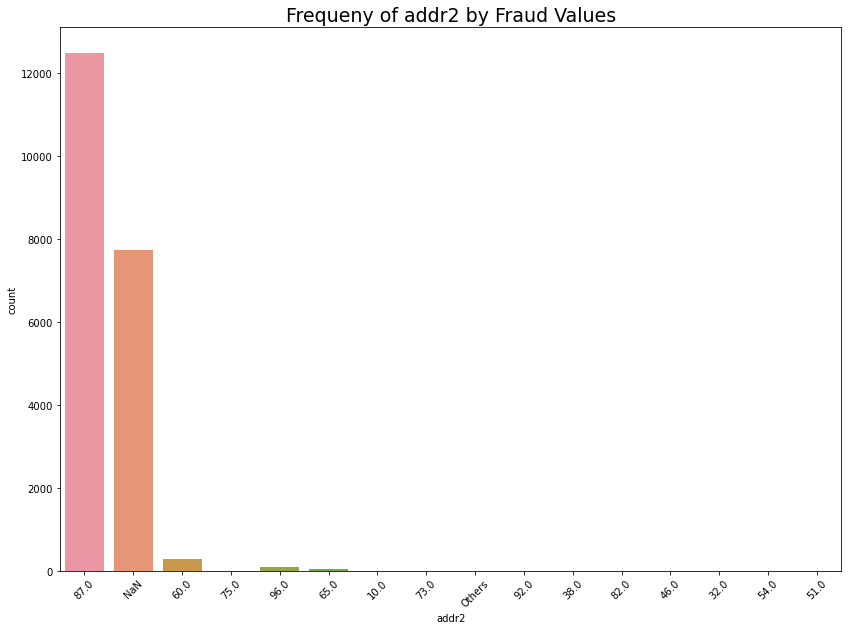

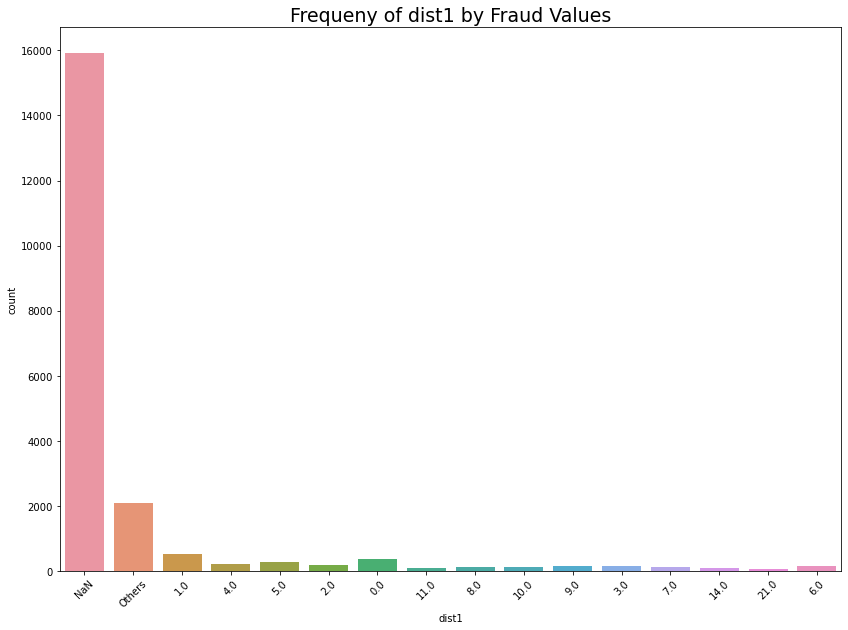

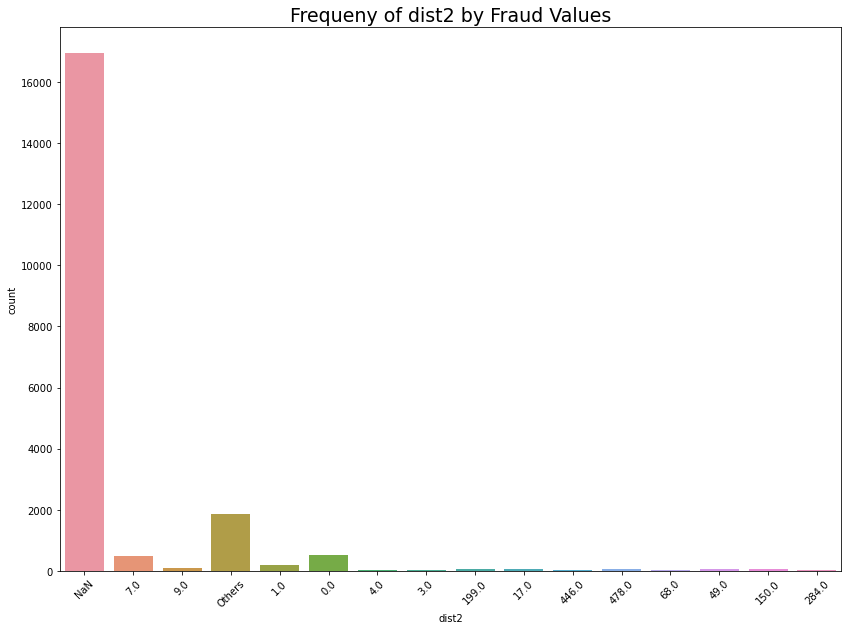

In [26]:
columns = D.columns

for col in columns:
    
    df_trans = df_tran[df_tran.isFraud==1][col]  
    
    
    plt.figure(figsize=(14,10))
    
    g1 = sns.countplot(x=df_trans)
    
    g1.set_title("Frequeny of " + str(col)+ " by Fraud Values", fontsize=19)
 
    g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
    plt.show()
  
    del g1
    
del D

- Missing values in addr1, addr2, dist1,dist2 have a higher fraud rate as well as in dist 1



- For cards 1 - 6 except 4  and 6

In [27]:
# Find which of the columns have the highest frquency among fake transactions
# Due to high presence of many features. Let's pick only the top features by frquency for plotting

df_trans = df_transaction[df_transaction['isFraud']==1]
df_tran = df_transaction.copy()
D = df_transaction[['card1','card2','card3','card5']]



for col in D.columns:
   
    index_list = df_trans[col].value_counts(ascending=False)[:15].index.to_list()
    df_tran.loc[df_tran[(~df_tran[col].isin(index_list))].index, col] = "Others"
    
    
del df_trans

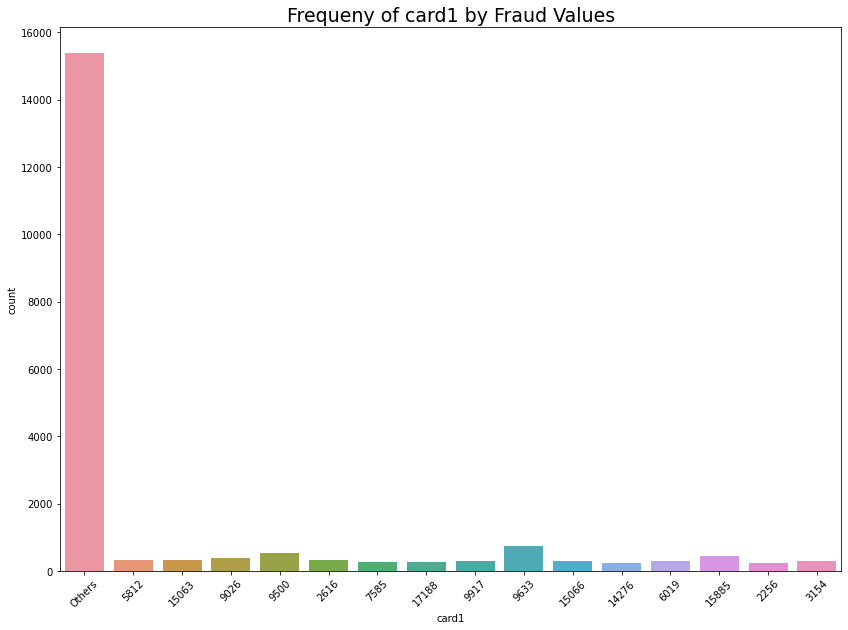

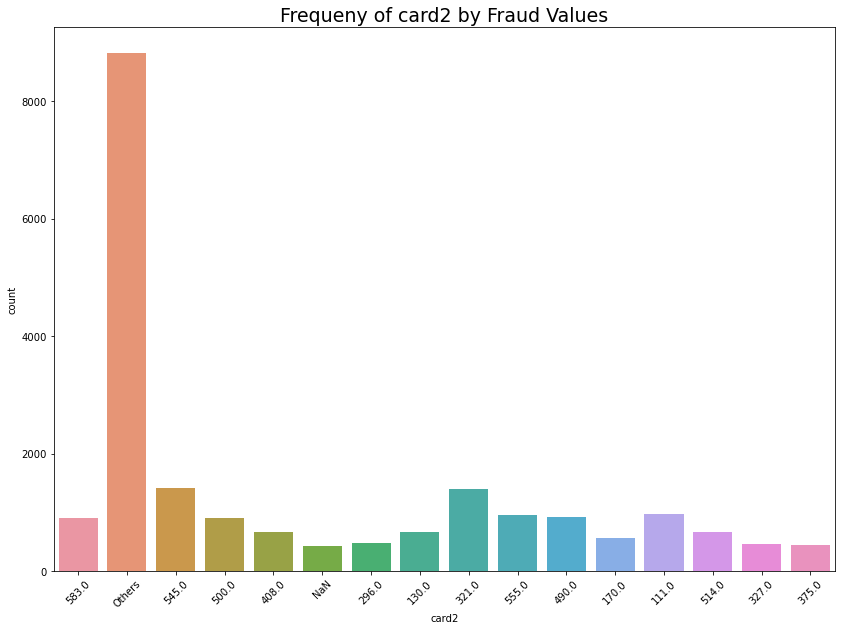

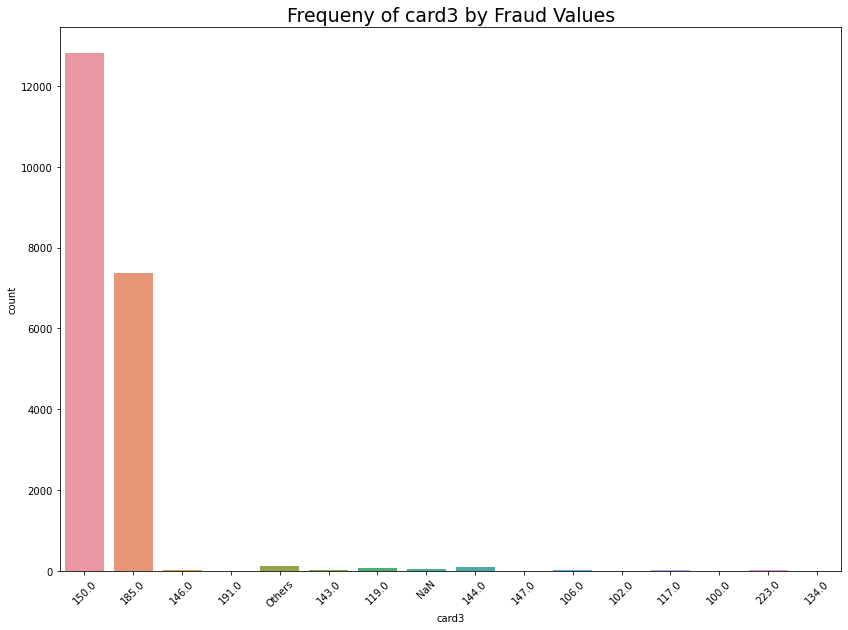

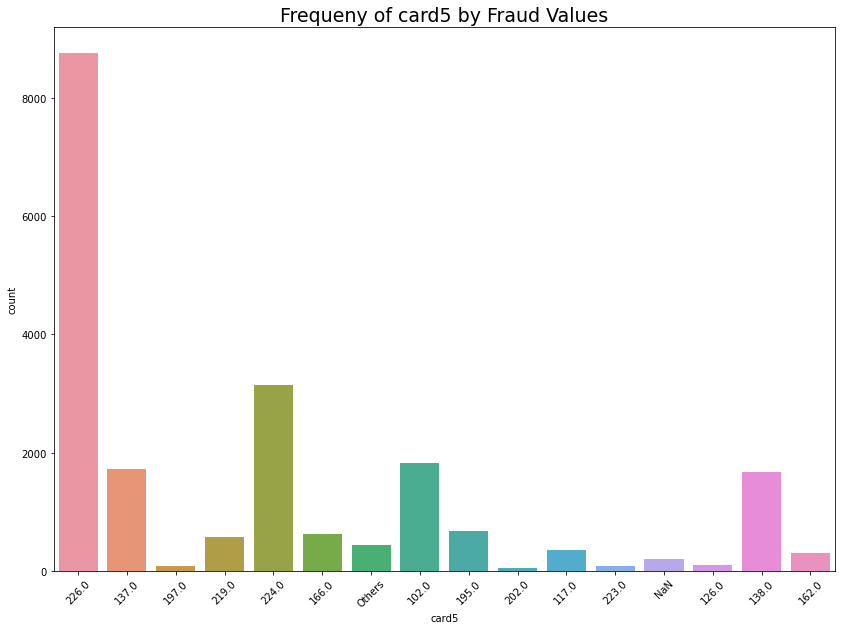

In [28]:
columns = D.columns

for col in columns:
    
    df_trans = df_tran[df_tran.isFraud==1][col]  
    
    
    plt.figure(figsize=(14,10))
    
    g1 = sns.countplot(x=df_trans)
    
    g1.set_title("Frequeny of " + str(col)+ " by Fraud Values", fontsize=19)
 
    g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
    plt.show()
  
    del g1
    
del D

- High number of low frequency values in card1, card2
- 150 and 185 have a high frequency for card 3 
- 226 have a high frequency for card 3

- TransactionDT
  - Break datetime into weekdays, hours and days
  - https://www.kaggle.com/c/ieee-fraud-detection/discussion/100400#latest-579480

In [29]:
START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
df_transaction["date"] = df_transaction['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))

df_transaction['Weekdays'] = df_transaction['date'].dt.dayofweek
df_transaction['Hours'] = df_transaction['date'].dt.hour
df_transaction['Days'] = df_transaction['date'].dt.day



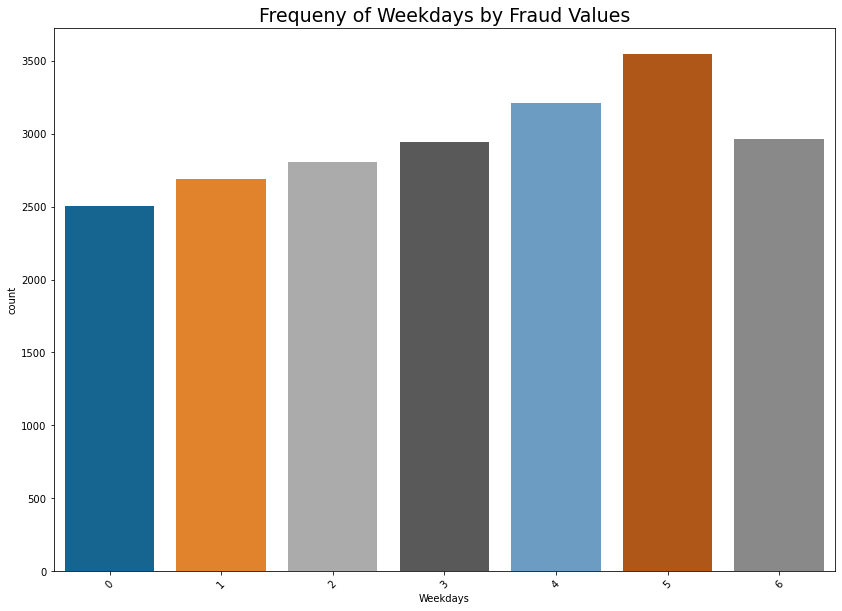

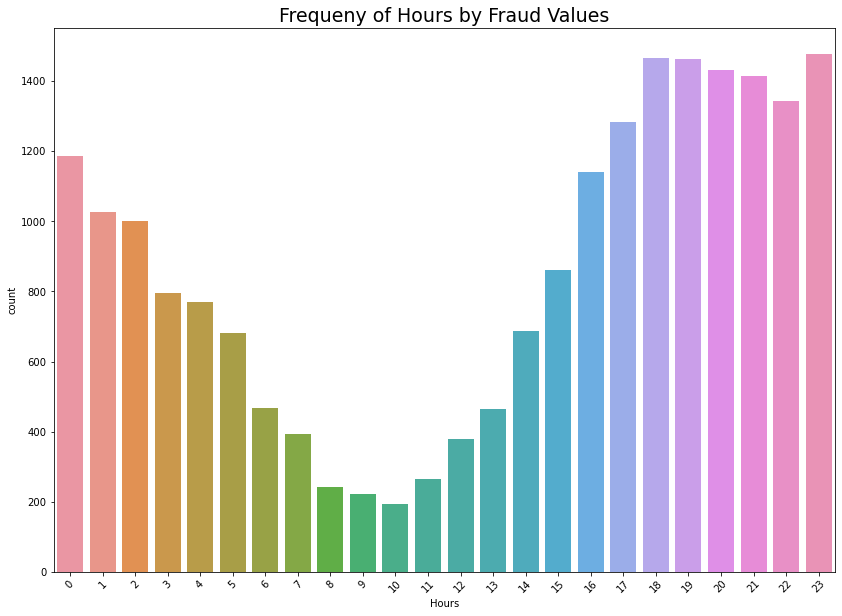

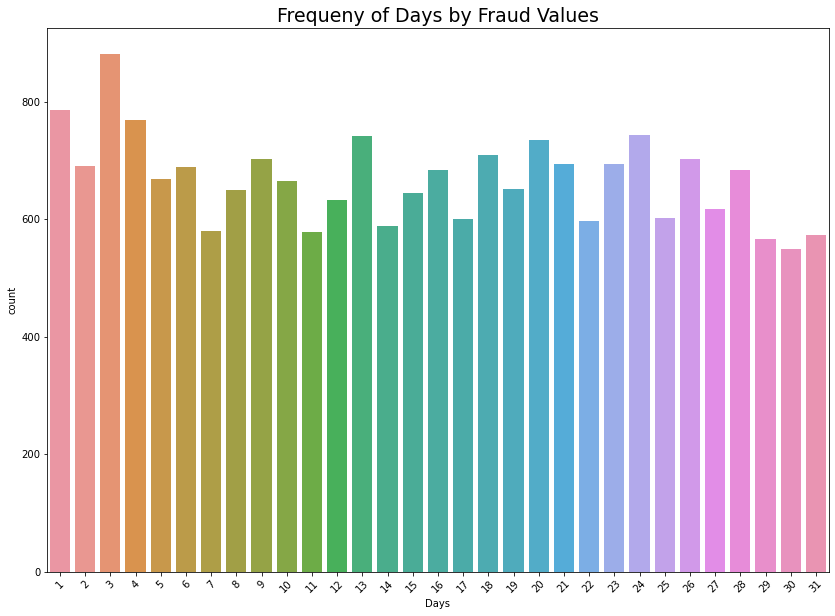

In [30]:
columns = ['Weekdays','Hours','Days']

for col in columns:
    
    df_trans = df_transaction[df_transaction.isFraud==1][col]  
    
    
    plt.figure(figsize=(14,10))
    
    g1 = sns.countplot(x=df_trans)
    
    g1.set_title("Frequeny of " + str(col)+ " by Fraud Values", fontsize=19)
 
    g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
    plt.show()
  
    del g1
    


- Fraud rate has a count on 5th working day and in the evening

In [31]:
truncated_df = df_transaction[['TransactionID','isFraud']]
del df_transaction

# Exploratory Data Analysis of Identity Database
- Here I will be performing EDA only on select columns with understandable data.

In [32]:
df_identity = pd.read_csv("../input/ieee-fraud-detection/train_identity.csv")

In [33]:
# Name of columns and null values among them

print(df_identity.columns)

print("NaN values : ",df_identity.isna().sum())

Index(['TransactionID', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06',
       'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14',
       'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22',
       'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30',
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object')
NaN values :  TransactionID         0
id_01                 0
id_02              3361
id_03             77909
id_04             77909
id_05              7368
id_06              7368
id_07            139078
id_08            139078
id_09             69307
id_10             69307
id_11              3255
id_12                 0
id_13             16913
id_14             64189
id_15              3248
id_16             14893
id_17              4864
id_18             99120
id_19              4915
id_20              4972
id_21            139074
id_22 

In [34]:
# Let's look at the data in the ID subset folder

ID = df_identity.filter(regex='^id',axis=1)
ID.head()

,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,...,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38
0,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T
1,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,...,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T
2,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,...,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T
3,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,...,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T
4,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,...,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T


In [35]:
print(ID.iloc[:,0:10])

        id_01     id_02  id_03  id_04  id_05  id_06  id_07  id_08  id_09  \
0         0.0   70787.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1        -5.0   98945.0    NaN    NaN    0.0   -5.0    NaN    NaN    NaN   
2        -5.0  191631.0    0.0    0.0    0.0    0.0    NaN    NaN    0.0   
3        -5.0  221832.0    NaN    NaN    0.0   -6.0    NaN    NaN    NaN   
4         0.0    7460.0    0.0    0.0    1.0    0.0    NaN    NaN    0.0   
...       ...       ...    ...    ...    ...    ...    ...    ...    ...   
144228  -15.0  145955.0    0.0    0.0    0.0    0.0    NaN    NaN    0.0   
144229   -5.0  172059.0    NaN    NaN    1.0   -5.0    NaN    NaN    NaN   
144230  -20.0  632381.0    NaN    NaN   -1.0  -36.0    NaN    NaN    NaN   
144231   -5.0   55528.0    0.0    0.0    0.0   -7.0    NaN    NaN    0.0   
144232  -45.0  339406.0    NaN    NaN  -10.0 -100.0    NaN    NaN    NaN   

        id_10  
0         NaN  
1         NaN  
2         0.0  
3         NaN  
4      

In [36]:
print(ID.iloc[:,10:20])

        id_11     id_12  id_13  id_14  id_15     id_16  id_17  id_18  id_19  \
0       100.0  NotFound    NaN -480.0    New  NotFound  166.0    NaN  542.0   
1       100.0  NotFound   49.0 -300.0    New  NotFound  166.0    NaN  621.0   
2       100.0  NotFound   52.0    NaN  Found     Found  121.0    NaN  410.0   
3       100.0  NotFound   52.0    NaN    New  NotFound  225.0    NaN  176.0   
4       100.0  NotFound    NaN -300.0  Found     Found  166.0   15.0  529.0   
...       ...       ...    ...    ...    ...       ...    ...    ...    ...   
144228  100.0  NotFound   27.0    NaN  Found     Found  225.0    NaN  427.0   
144229  100.0  NotFound   27.0 -300.0    New  NotFound  166.0   15.0  352.0   
144230  100.0  NotFound   27.0    NaN    New  NotFound  225.0   27.0  567.0   
144231  100.0  NotFound   27.0 -300.0  Found     Found  166.0   15.0  352.0   
144232  100.0  NotFound   27.0    NaN    New  NotFound  225.0   15.0  417.0   

        id_20  
0       144.0  
1       500.0  
2  

In [37]:
print(ID.iloc[:,20:30])

        id_21  id_22 id_23  id_24  id_25  id_26 id_27  id_28     id_29  \
0         NaN    NaN   NaN    NaN    NaN    NaN   NaN    New  NotFound   
1         NaN    NaN   NaN    NaN    NaN    NaN   NaN    New  NotFound   
2         NaN    NaN   NaN    NaN    NaN    NaN   NaN  Found     Found   
3         NaN    NaN   NaN    NaN    NaN    NaN   NaN    New  NotFound   
4         NaN    NaN   NaN    NaN    NaN    NaN   NaN  Found     Found   
...       ...    ...   ...    ...    ...    ...   ...    ...       ...   
144228    NaN    NaN   NaN    NaN    NaN    NaN   NaN  Found     Found   
144229    NaN    NaN   NaN    NaN    NaN    NaN   NaN    New  NotFound   
144230    NaN    NaN   NaN    NaN    NaN    NaN   NaN    New  NotFound   
144231    NaN    NaN   NaN    NaN    NaN    NaN   NaN  Found     Found   
144232    NaN    NaN   NaN    NaN    NaN    NaN   NaN    New  NotFound   

                   id_30  
0            Android 7.0  
1             iOS 11.1.2  
2                    NaN  
3  

In [38]:
print(ID.iloc[:,30:40])

                          id_31  id_32      id_33           id_34 id_35 id_36  \
0           samsung browser 6.2   32.0  2220x1080  match_status:2     T     F   
1            mobile safari 11.0   32.0   1334x750  match_status:1     T     F   
2                   chrome 62.0    NaN        NaN             NaN     F     F   
3                   chrome 62.0    NaN        NaN             NaN     F     F   
4                   chrome 62.0   24.0   1280x800  match_status:2     T     F   
...                         ...    ...        ...             ...   ...   ...   
144228  chrome 66.0 for android    NaN        NaN             NaN     F     F   
144229  chrome 55.0 for android   32.0    855x480  match_status:2     T     F   
144230  chrome 65.0 for android    NaN        NaN             NaN     F     F   
144231              chrome 66.0   24.0  2560x1600  match_status:2     T     F   
144232  chrome 66.0 for android    NaN        NaN             NaN     F     F   

       id_37 id_38  
0     

In [39]:
# Merge the targets and identity database for plotting purpose

df_identity = pd.merge(truncated_df,df_identity, how='left',on='TransactionID')
df_identity.reset_index(inplace=True)

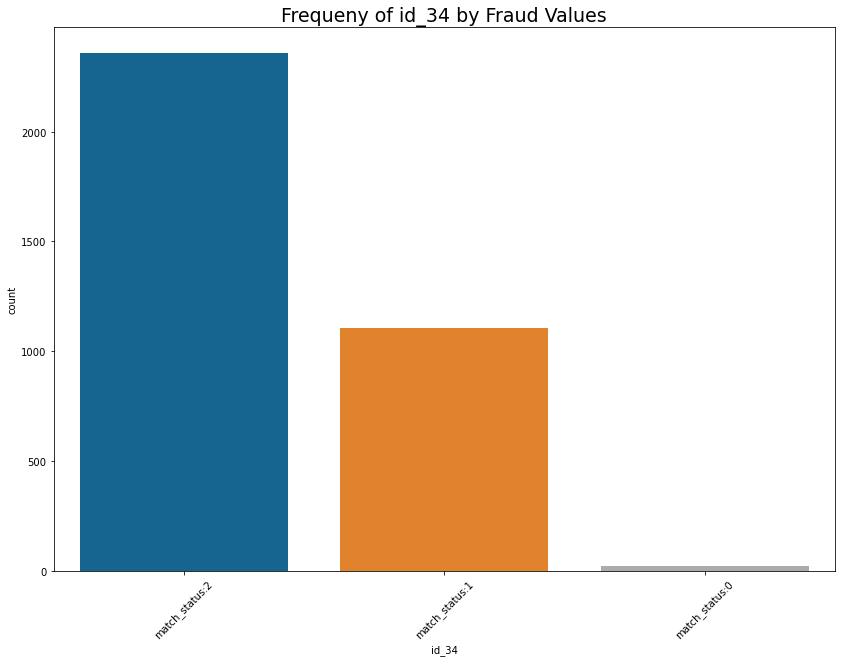

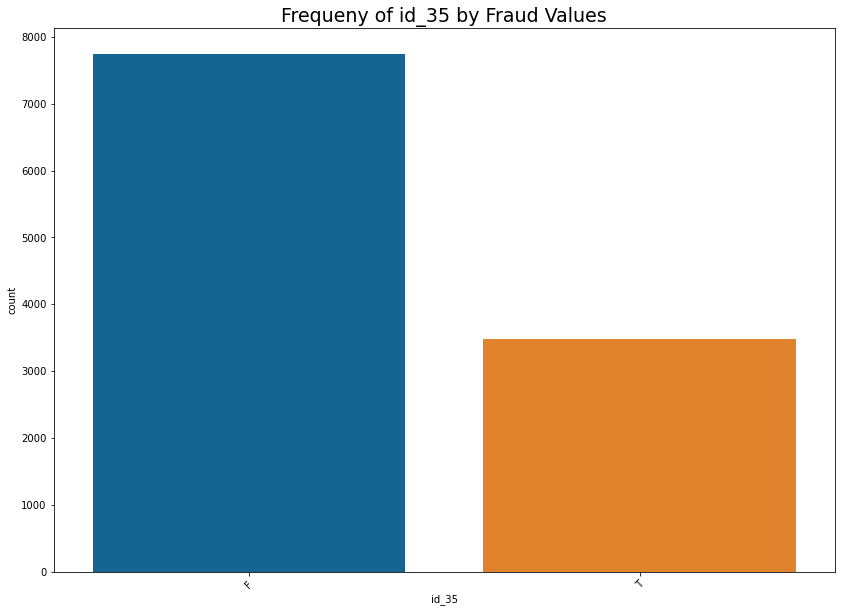

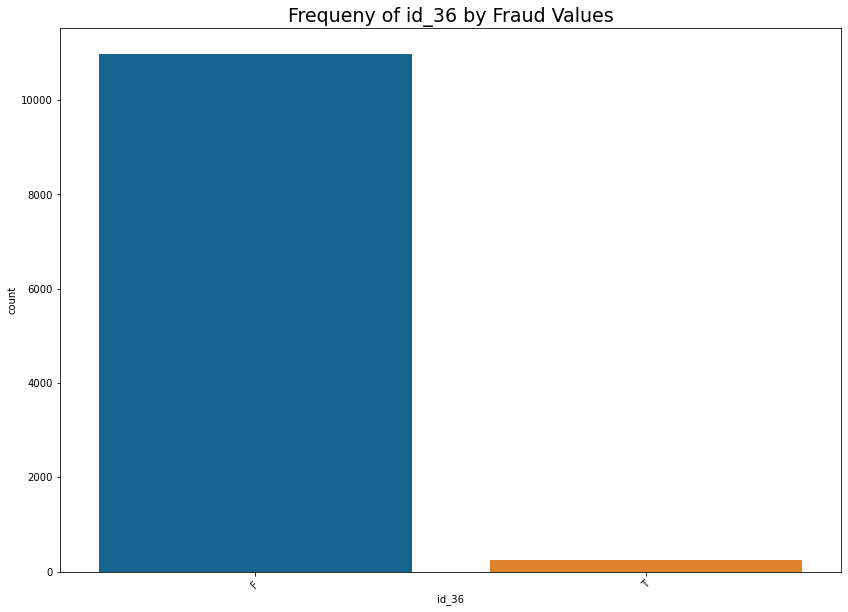

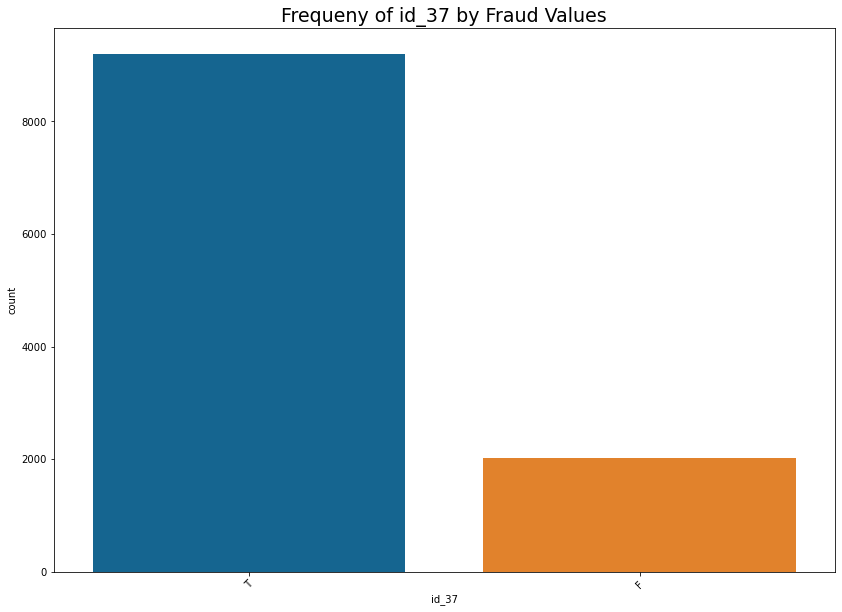

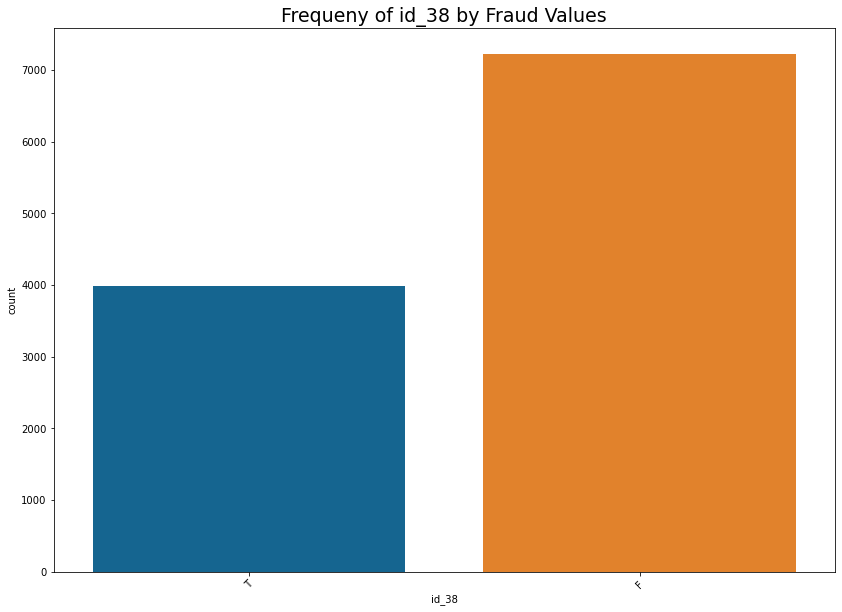

In [40]:
columns = ['id_34','id_35','id_36','id_37','id_38']

for col in columns:
    
    df_iden = df_identity[df_identity.isFraud==1][col]  
    
    
    plt.figure(figsize=(14,10))
    
    g1 = sns.countplot(x=df_iden)
    
    g1.set_title("Frequeny of " + str(col)+ " by Fraud Values", fontsize=19)
 
    g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
    plt.show()
  
    del g1
    

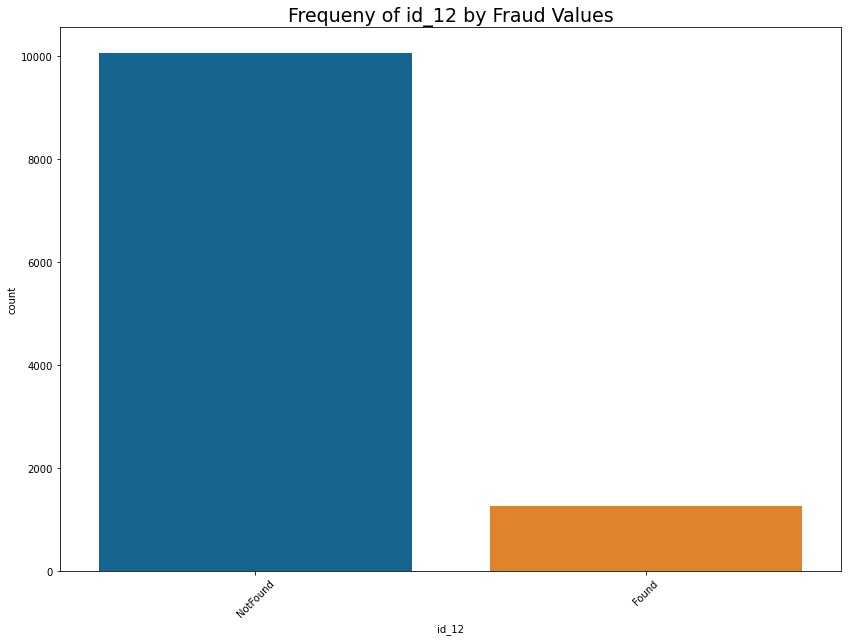

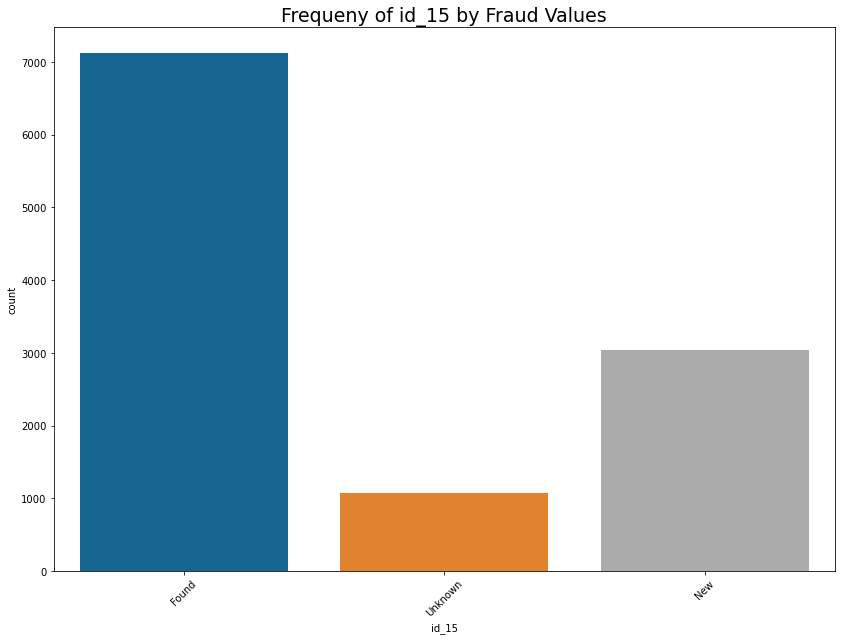

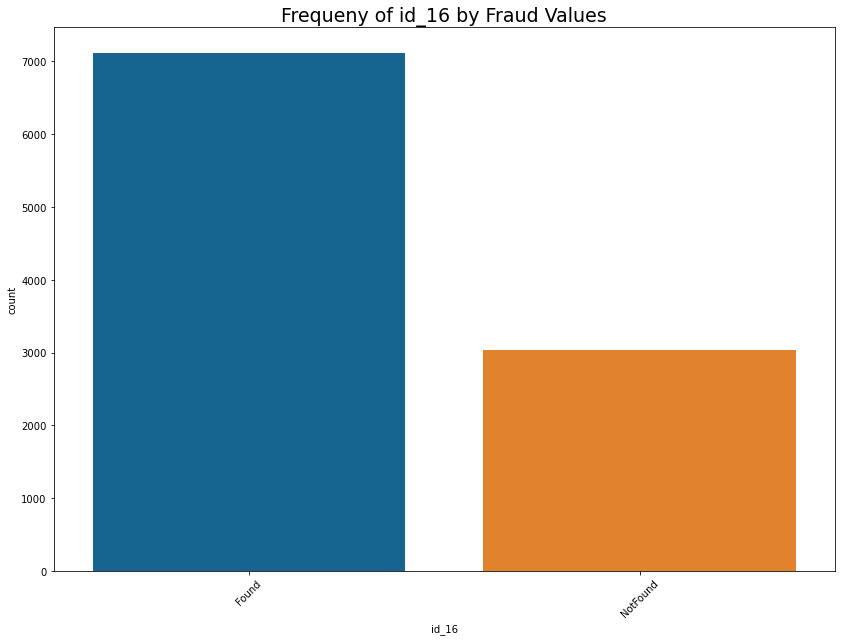

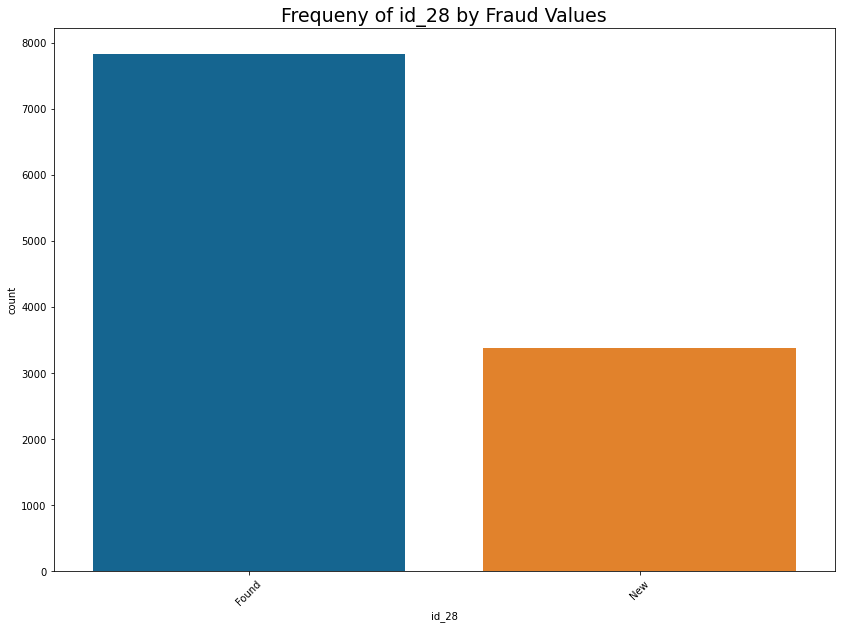

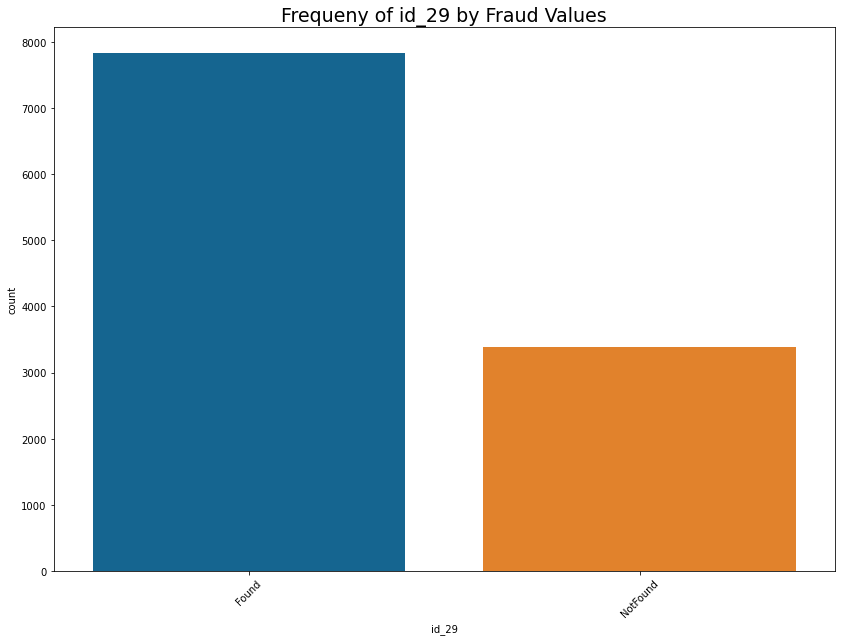

In [41]:
columns = ['id_12','id_15','id_16','id_28','id_29']

for col in columns:
    
    df_iden = df_identity[df_identity.isFraud==1][col]  
    
    
    plt.figure(figsize=(14,10))
    
    g1 = sns.countplot(x=df_iden)
    
    g1.set_title("Frequeny of " + str(col)+ " by Fraud Values", fontsize=19)
 
    g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
    plt.show()
  
    del g1
    
 
    

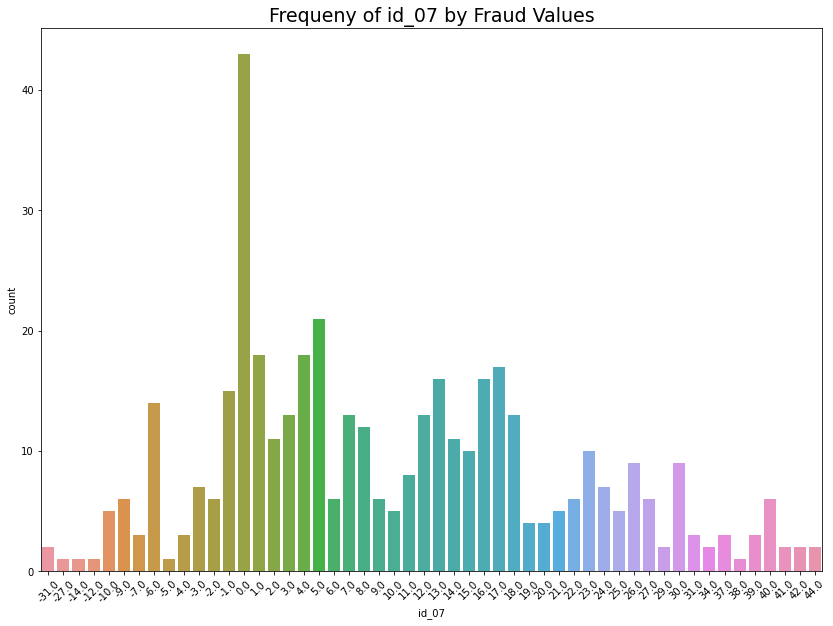

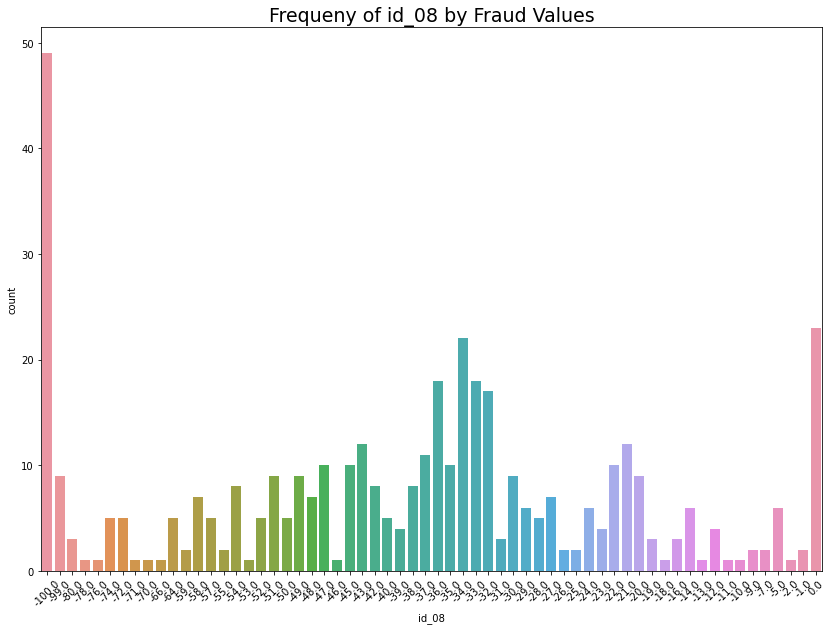

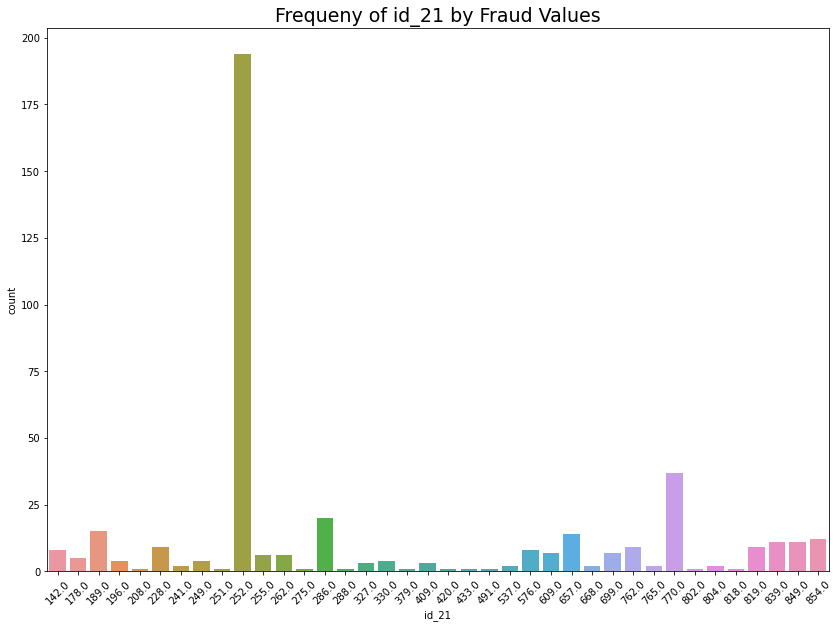

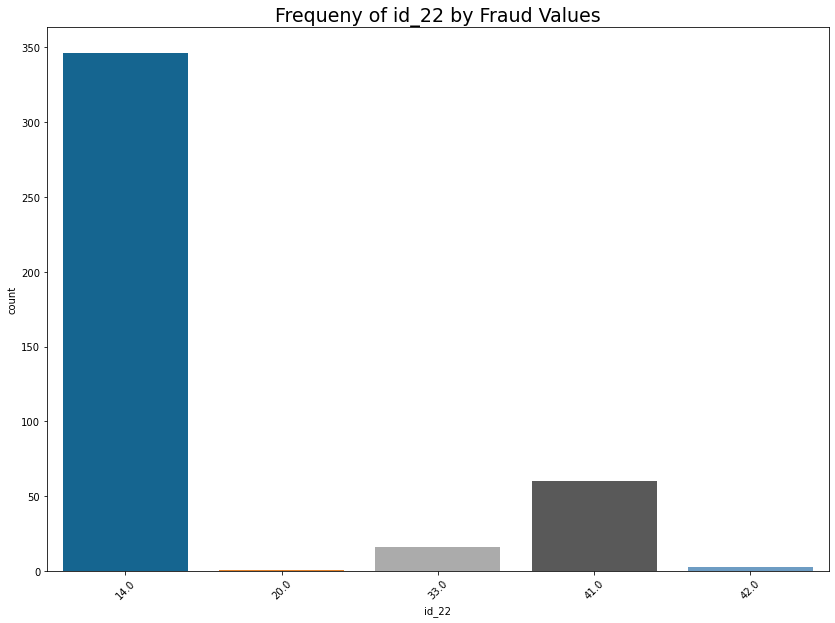

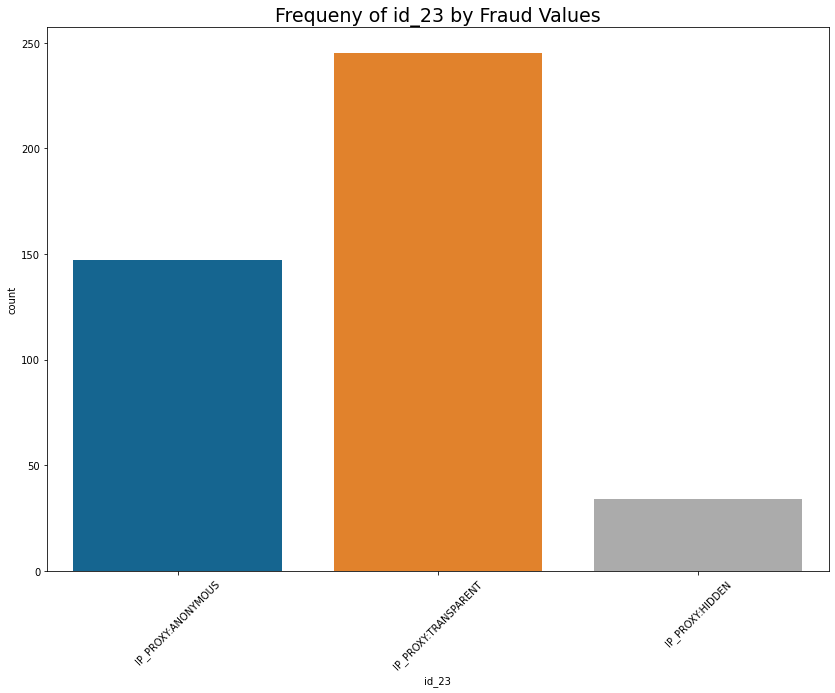

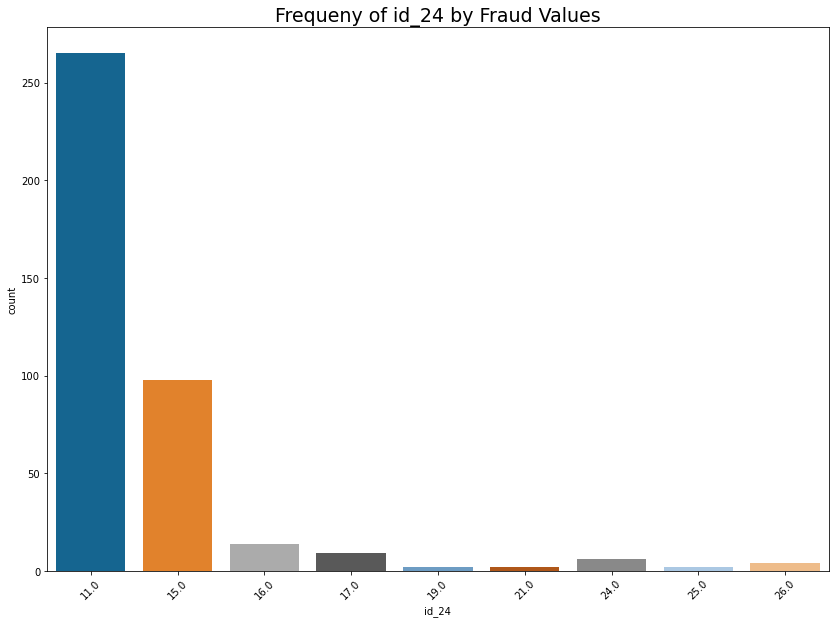

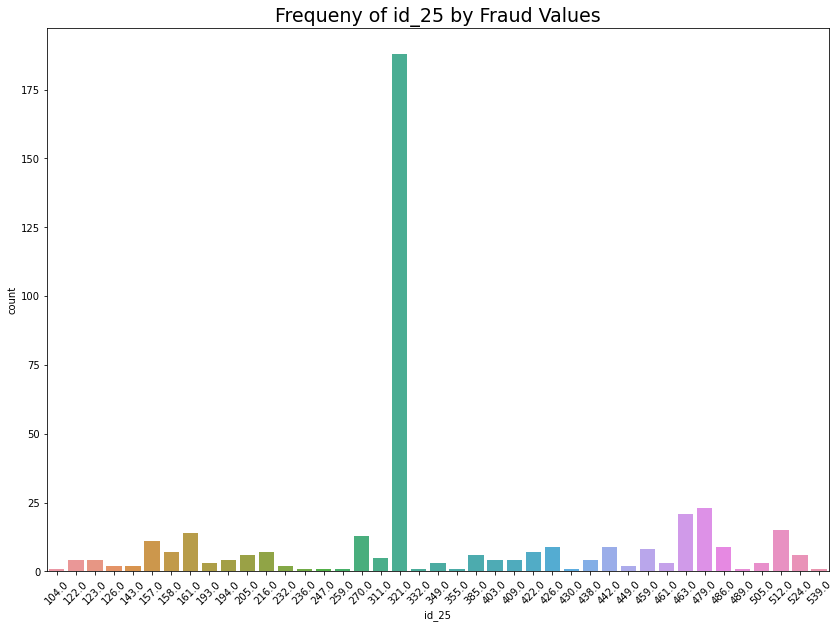

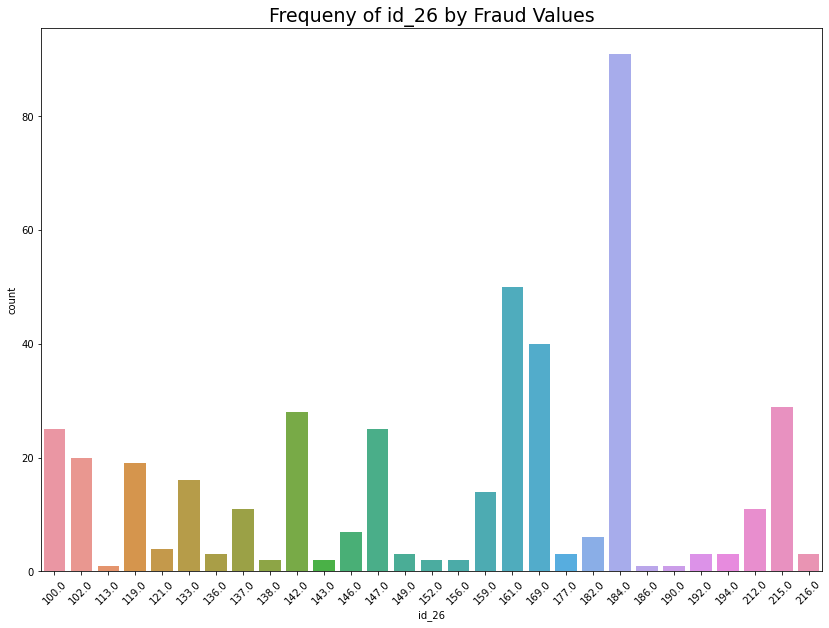

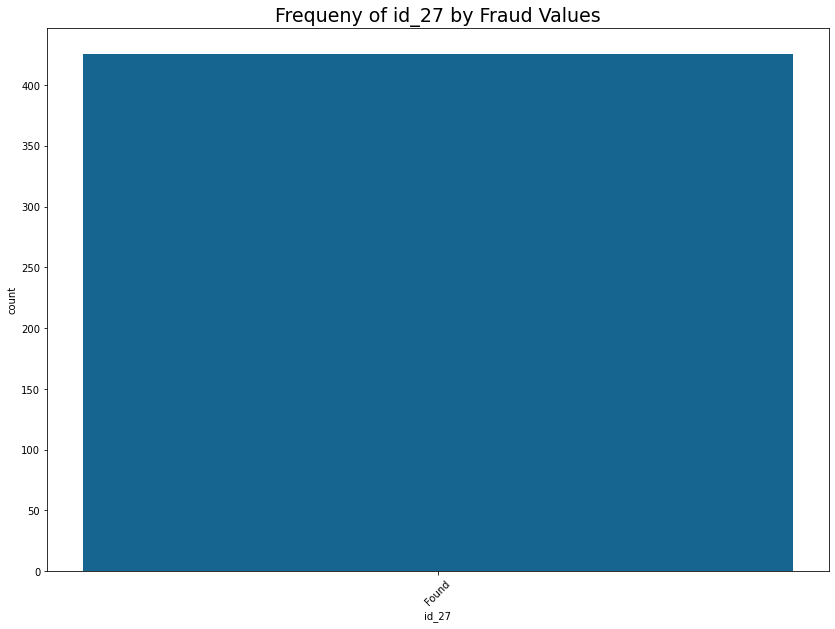

In [42]:
# ID columns with high number of NaN values

columns =['id_07', 'id_08', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27']


for col in columns:
    
    df_iden = df_identity[df_identity.isFraud==1][col]  
    
    
    plt.figure(figsize=(14,10))
    
    g1 = sns.countplot(x=df_iden)
    
    g1.set_title("Frequeny of " + str(col)+ " by Fraud Values", fontsize=19)
 
    g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
    plt.show()
  
    del g1

- Interesting result in id_23 and id_27
- id_23 has dist of IP address. There are high frequency values in anonymous (not higher than transparent)
- id_27 shows 'Found' throughout
- It would be valid to keep the High NaN columns

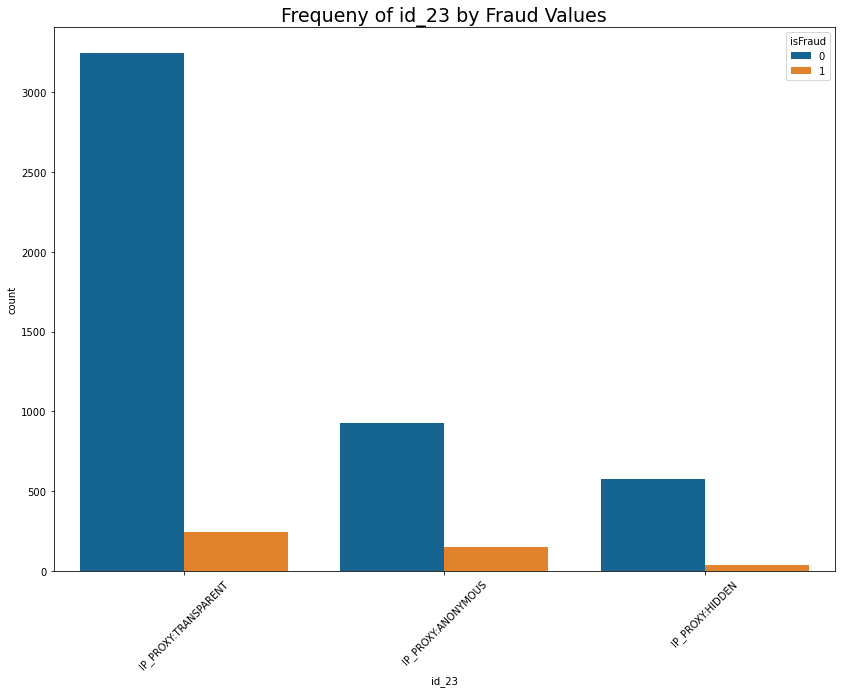

In [43]:
# Further analysis of id_23

  
plt.figure(figsize=(14,10))
    
g1 = sns.countplot(x='id_23',hue='isFraud',data=df_identity)
    
g1.set_title("Frequeny of " + "id_23" + " by Fraud Values", fontsize=19)
 
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
plt.show()

del g1

- Higher tedency for anonymous IP ratio wise

In [44]:
# Find which of the columns have the highest frquency among fake transactions
# Due to high presence of many features. Let's pick only the top features by frquency for plotting

df_ident =df_identity[df_identity['isFraud']==1]
df_iden = df_identity.copy()
D = df_identity[['id_30','id_31','id_33','DeviceInfo']]



for col in D.columns:
   
    index_list = df_ident[col].value_counts(ascending=False)[:15].index.to_list()
    df_iden.loc[df_iden[(~df_iden[col].isin(index_list))].index, col] = "Others"
    
    
del df_ident

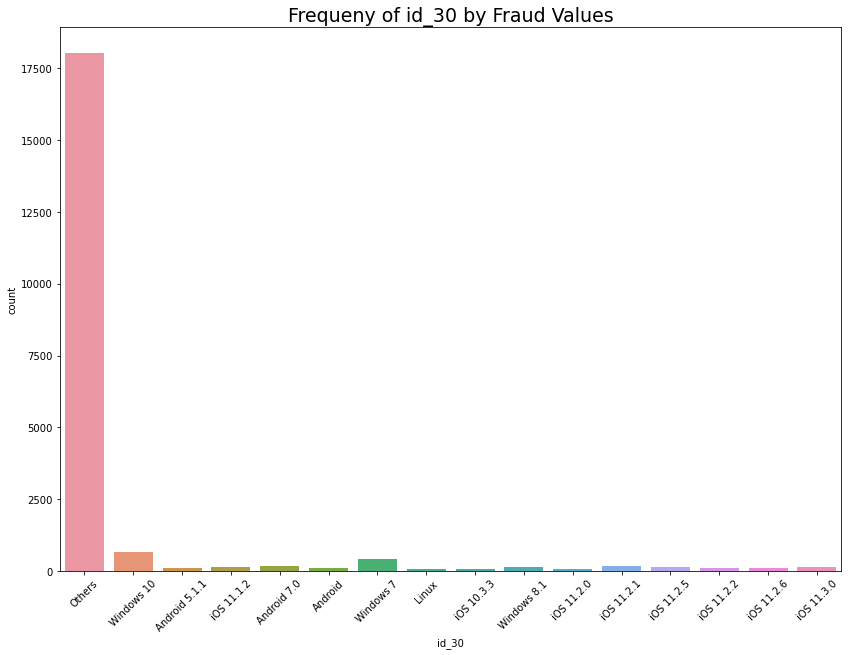

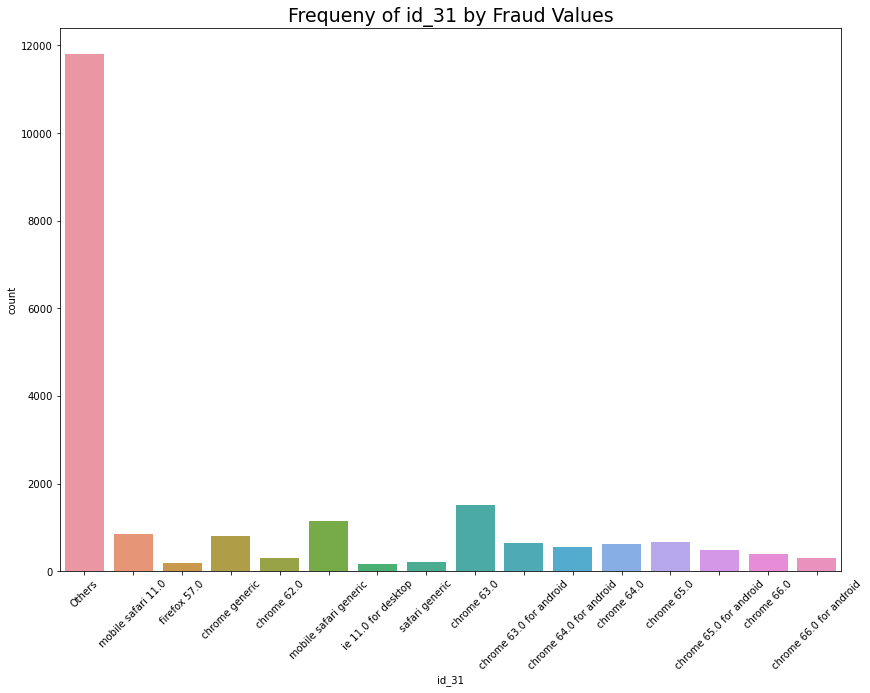

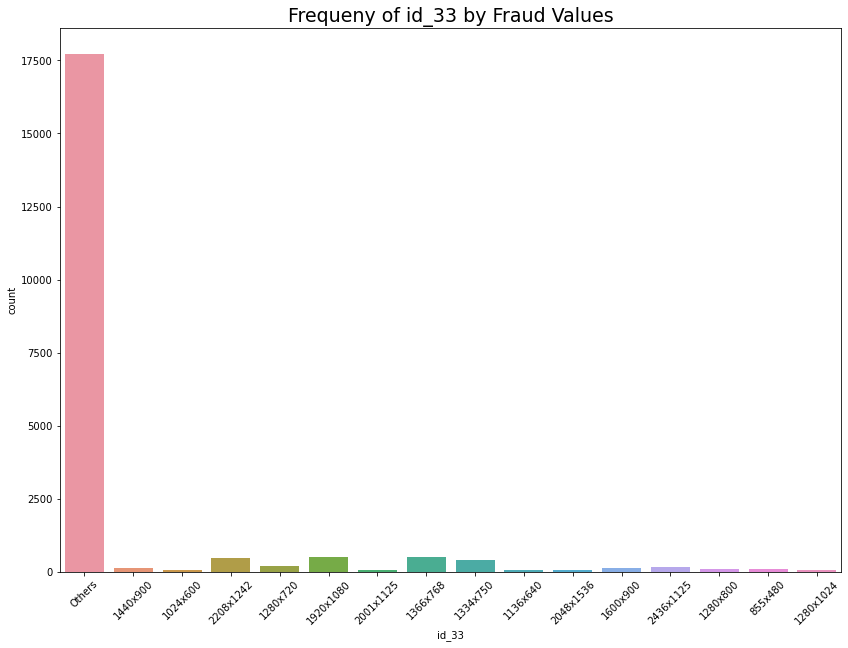

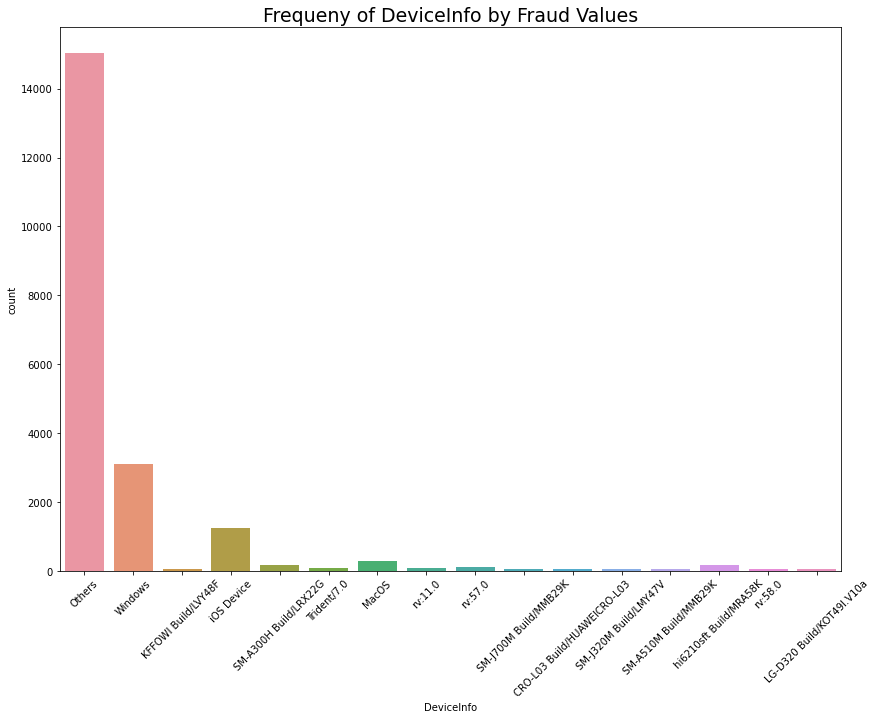

In [45]:
columns = D.columns


for col in columns:
    
    df_ident = df_iden[df_iden.isFraud==1][col]  
    
    
    plt.figure(figsize=(14,10))
    
    g1 = sns.countplot(x=df_ident)
    
    g1.set_title("Frequeny of " + str(col)+ " by Fraud Values", fontsize=19)
 
    g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
    plt.show()
  
    del g1
    
del df_iden

  


- High amount of Fraud among low frequency values
- It would be advisable to take a higher size for prediction


# Applying information we have learnt and implementing LightGBM on the training set first

In [46]:
df_trans = pd.read_csv("../input/ieee-fraud-detection/train_transaction.csv")
df_identity = pd.read_csv("../input/ieee-fraud-detection/train_identity.csv")

In [47]:
# Data Merging
df = pd.merge(df_trans,df_identity, how='left',on='TransactionID')
df.reset_index(inplace=True)
del df_trans,df_identity

In [48]:
df.drop(columns=['index'],inplace=True)

- We then pick the values in the corresponding columns with high frequency from Fraudelent and non Fraudenlent case.
- This ensures that the prediction works well for the most frequent values in both cases

In [49]:
def pick_high_freq_only(df,df2 = pd.DataFrame(),second=False):
    
    # Find which of the columns have the highest frquency among fake transactions
    
    # Device Info
    d = df[df['isFraud']==1]
    dnf = df[df['isFraud']==0]
    columns  = ['DeviceInfo']


    for col in columns:
   
        index_list1 = d[col].value_counts(ascending=False)[:100].index.to_list()
        index_list2 = dnf[col].value_counts(ascending=False)[:100].index.to_list()
    
        index_list = index_list1 + index_list2
        df.loc[df[(~df[col].isin(index_list))].index, col] = "Others"
    
        if second == True:
            df2.loc[df2[(~df2[col].isin(index_list))].index, col] = "Others"
    
    
    del d,dnf
    
    # Email Domains
    d = df[df['isFraud']==1]
    dnf = df[df['isFraud']==0]
    columns  = ['P_emaildomain', 'R_emaildomain']


    for col in columns:
   
        index_list1 = d[col].value_counts(ascending=False)[:20].index.to_list()
        index_list2 = dnf[col].value_counts(ascending=False)[:20].index.to_list()
    
        index_list = index_list1 + index_list2
        df.loc[df[(~df[col].isin(index_list))].index, col] = "Others"
        
        if second == True:
            df2.loc[df2[(~df2[col].isin(index_list))].index, col] = "Others"
            
    
    
    
    del d,dnf
    
    # Selected ID's
    d = df[df['isFraud']==1]
    dnf = df[df['isFraud']==0]
    columns = ['id_30','id_31','id_33']

    for col in columns:
   
        index_list1 = d[col].value_counts(ascending=False)[:100].index.to_list()
        index_list2 = dnf[col].value_counts(ascending=False)[:100].index.to_list()
    
        index_list = index_list1 + index_list2
        df.loc[df[(~df[col].isin(index_list))].index, col] = "Others"
        
        if second == True:
            df2.loc[df2[(~df2[col].isin(index_list))].index, col] = "Others"
    
    
    del d,dnf
    
    return df,df2




df,_ = pick_high_freq_only(df)
    
#print(df)  

In [50]:
# Seggregate into features and target

Features = df
Features = Features.drop(columns=['isFraud','TransactionID'])
Target = df['isFraud'].astype(float)
Target = Target.values
Target = Target.reshape((len(Target), 1))

del df

- Feature Engineering with TransactionDT

In [51]:
def FETransactionDT(Features):
    
    #print(Features)
    START_DATE = '2017-12-01'
    startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
    Features["date"] = Features['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))

    Features['Weekdays'] = Features['date'].dt.dayofweek
    Features['Hours'] = Features['date'].dt.hour
    Features['Days'] = Features['date'].dt.day

    Features['Weekdays'] = pd.to_numeric(Features['Weekdays'])
    Features['Hours'] = pd.to_numeric(Features['Hours'])
    Features['Days'] = pd.to_numeric(Features['Days'])

    Features.drop(columns=["date"],inplace=True)
    
    return Features
    
Features = FETransactionDT(Features)


- Drop columns with high number of NaN values

In [52]:
def HighNaNcol(Features):
    
    HighNaN = []
    for col in Features.columns:
    
        no = Features[col].isna().sum()
    
        if no > 0.95 * len(Features):
            HighNaN.append(col)
            
    print(HighNaN)
    return HighNaN

#HighNaN = HighNaNcol(Features)


In [53]:
# Features to drop 
columns_to_drop = HighCorrVDrop


#Features.drop(columns=HighNaN,inplace=True)
Features.drop(columns = columns_to_drop,inplace=True)

In [54]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(Features, Target, test_size=test_size,random_state=32)

-  Scale the Categorical and Numerical columns

In [55]:
def ScaleColumns(X_train,X_test):
    for col in X_train.columns:
        if X_train[col].dtype=='object' or X_test[col].dtype=='object': 
            print(col)
            lbl = preprocessing.LabelEncoder()
        
            X_train[col] = X_train[col].astype(str)
            X_test[col] = X_test[col].astype(str)
        
            X_train[col] = lbl.fit_transform(X_train[col])
            X_test[col] = lbl.transform(X_test[col])  
        
        if col == 'TransactionAmt':
            
            print(col)
            SS = preprocessing.StandardScaler()
        
            X_train_arr = X_train[col].astype(float).values
            X_test_arr = X_test[col].astype(float).values   
        
            
            X_train_arr = SS.fit_transform(X_train_arr.reshape(-1,1))
            X_test_arr = SS.transform(X_test_arr.reshape(-1,1))
            
            X_train[col]  = X_train_arr 
            X_test[col]   = X_test_arr
            
    return X_train, X_test
            
X_train, X_test = ScaleColumns(X_train,X_test)

TransactionAmt
ProductCD
card4
card6
P_emaildomain
R_emaildomain
M1
M2
M3
M4
M5
M6
M7
M8
M9
id_12
id_15
id_16
id_23
id_27
id_28
id_29
id_30
id_31
id_33
id_34
id_35
id_36
id_37
id_38
DeviceType
DeviceInfo


- RandomSearchCV Search for LightGBM

In [56]:

#fit_params={"early_stopping_rounds":50, 
           # "eval_metric" : 'auc', 
           #"eval_set" : [(X_test,y_test)],
           #'eval_names': ['valid'],
           # 'verbose': 100,
           #'categorical_feature': 'auto'}

#param_test ={  'n_estimators': [400, 700, 1000],
  #'colsample_bytree': [0.7, 0.8],
  # 'max_depth': [15,20,25],
   #'num_leaves': [50, 100, 200],
  # 'reg_alpha': [1.1, 1.2, 1.3],
 # 'reg_lambda': [1.1, 1.2, 1.3],
 # 'min_split_gain': [0.3, 0.4],
 #'subsample': [0.7, 0.8, 0.9],
  # 'subsample_freq': [20]}

In [57]:
#clf = LGBMClassifier(random_state=314, silent=True, metric='None', n_jobs=2)
#model = RandomizedSearchCV(
  # estimator=clf, param_distributions=param_test, 
   # scoring='roc_auc',
   # cv=3,
    #refit=True,
   # random_state=314,
   # verbose=True)

In [58]:
#model.fit(X_train, y_train, **fit_params)
#print('Best score reached: {} with params: {} '.format(model.best_score_, model.best_params_))

- Model fitting using LGBM classifier
- The hyperparameters are found using a RandomizedSearchCV (commented above)

In [59]:

model = LGBMClassifier(subsample_freq= 20,subsample= 0.7, reg_lambda= 1.2, reg_alpha = 1.1, 
                       num_leaves = 200, n_estimators = 700, 
                       min_split_gain = 0.3, max_depth = 25, colsample_bytre = 0.8,random_state=314,n_jobs=2)

model.fit(X_train, y_train)

LGBMClassifier(colsample_bytre=0.8, max_depth=25, min_split_gain=0.3,
               n_estimators=700, n_jobs=2, num_leaves=200, random_state=314,
               reg_alpha=1.1, reg_lambda=1.2, subsample=0.7, subsample_freq=20)

In [60]:
# make predictions for test data
y_pred = model.predict_proba(X_test)

In [61]:
# evaluate predictions
score = roc_auc_score(y_test, y_pred[:,1])
print("ROC_AUC score: %.2f%%" % (score * 100.0))

ROC_AUC score: 96.93%


# Implement model on test set

In [62]:
df_train_trans = pd.read_csv("../input/ieee-fraud-detection/train_transaction.csv")
df_train_identity = pd.read_csv("../input/ieee-fraud-detection/train_identity.csv")

# Data Merging
df_train = pd.merge(df_train_trans,df_train_identity , how='left',on='TransactionID')
df_train.reset_index(inplace=True)
del df_train_trans,df_train_identity

In [63]:
df_test_trans = pd.read_csv("../input/ieee-fraud-detection/test_transaction.csv")
df_test_identity = pd.read_csv("../input/ieee-fraud-detection/test_identity.csv")

# Data Merging
df_test = pd.merge(df_test_trans,df_test_identity , how='left',on='TransactionID')
df_test.reset_index(inplace=True)
del df_test_trans,df_test_identity

In [64]:
df_train.drop(columns=['index'],inplace=True)
df_test.drop(columns=['index'],inplace=True)

- Feature Engineering
   - Replace values with low value count with 'Others'
   - Create columns splitting datetime into components
   - Drop highly correlatted V columns
   - Drop columns with high NaN values

In [65]:
df_test.columns = df_test.columns.str.replace("-", "_")
print(df_test.columns)

Index(['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD',
       'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       ...
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=433)


In [66]:
df_train,df_test = pick_high_freq_only(df_train,df_test,second=True)

In [67]:
# Seggregate into features and target

Features_train = df_train
Features_train = Features_train.drop(columns=['isFraud'])
Target_train = df_train['isFraud']
Target_train = Target_train.values
Target_train = Target_train.reshape((len(Target_train), 1))

del df_train

In [68]:
Features_test = df_test

del df_test

In [69]:
Features_train = FETransactionDT(Features_train)
Features_test = FETransactionDT(Features_test)

In [70]:
HighNaN = HighNaNcol(Features_train)

['id_07', 'id_08', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27']


In [71]:
# Features to drop 
columns_to_drop = HighCorrVDrop

#Features_train.drop(columns=HighNaN,inplace=True)
Features_train.drop(columns = columns_to_drop,inplace=True)

#Features_test.drop(columns=HighNaN,inplace=True)
Features_test.drop(columns = columns_to_drop,inplace=True)

In [72]:
Features_train, Features_test = ScaleColumns(Features_train, Features_test)

TransactionAmt
ProductCD
card4
card6
P_emaildomain
R_emaildomain
M1
M2
M3
M4
M5
M6
M7
M8
M9
id_12
id_15
id_16
id_23
id_27
id_28
id_29
id_30
id_31
id_33
id_34
id_35
id_36
id_37
id_38
DeviceType
DeviceInfo


In [73]:
Features_train = Features_train.drop(columns=['TransactionID'])
Features_test_without_ID = Features_test.drop(columns=['TransactionID'])

In [74]:

model = LGBMClassifier(subsample_freq= 20,subsample= 0.7, reg_lambda= 1.2, reg_alpha = 1.1, 
                       num_leaves = 200, n_estimators = 700, 
                       min_split_gain = 0.3, max_depth = 25, colsample_bytre = 0.8,random_state=314,n_jobs=2)

model.fit(Features_train, Target_train)

LGBMClassifier(colsample_bytre=0.8, max_depth=25, min_split_gain=0.3,
               n_estimators=700, n_jobs=2, num_leaves=200, random_state=314,
               reg_alpha=1.1, reg_lambda=1.2, subsample=0.7, subsample_freq=20)

In [75]:
# make predictions for test data
y_pred = model.predict_proba(Features_test_without_ID)


In [76]:
print(y_pred)

[[9.97838762e-01 2.16123770e-03]
 [9.99277511e-01 7.22488653e-04]
 [9.98014455e-01 1.98554549e-03]
 ...
 [9.96697315e-01 3.30268535e-03]
 [9.92122200e-01 7.87779969e-03]
 [9.95991629e-01 4.00837109e-03]]


In [77]:
submission = pd.DataFrame()
submission['TransactionID'] = Features_test['TransactionID']
submission['isFraud'] = y_pred[:,1]

print(submission)


        TransactionID   isFraud
0             3663549  0.002161
1             3663550  0.000722
2             3663551  0.001986
3             3663552  0.002271
4             3663553  0.000465
...               ...       ...
506686        4170235  0.005923
506687        4170236  0.004651
506688        4170237  0.003303
506689        4170238  0.007878
506690        4170239  0.004008

[506691 rows x 2 columns]


In [78]:
submission.to_csv('submission.csv', index=False)

# Feature Importance Chart

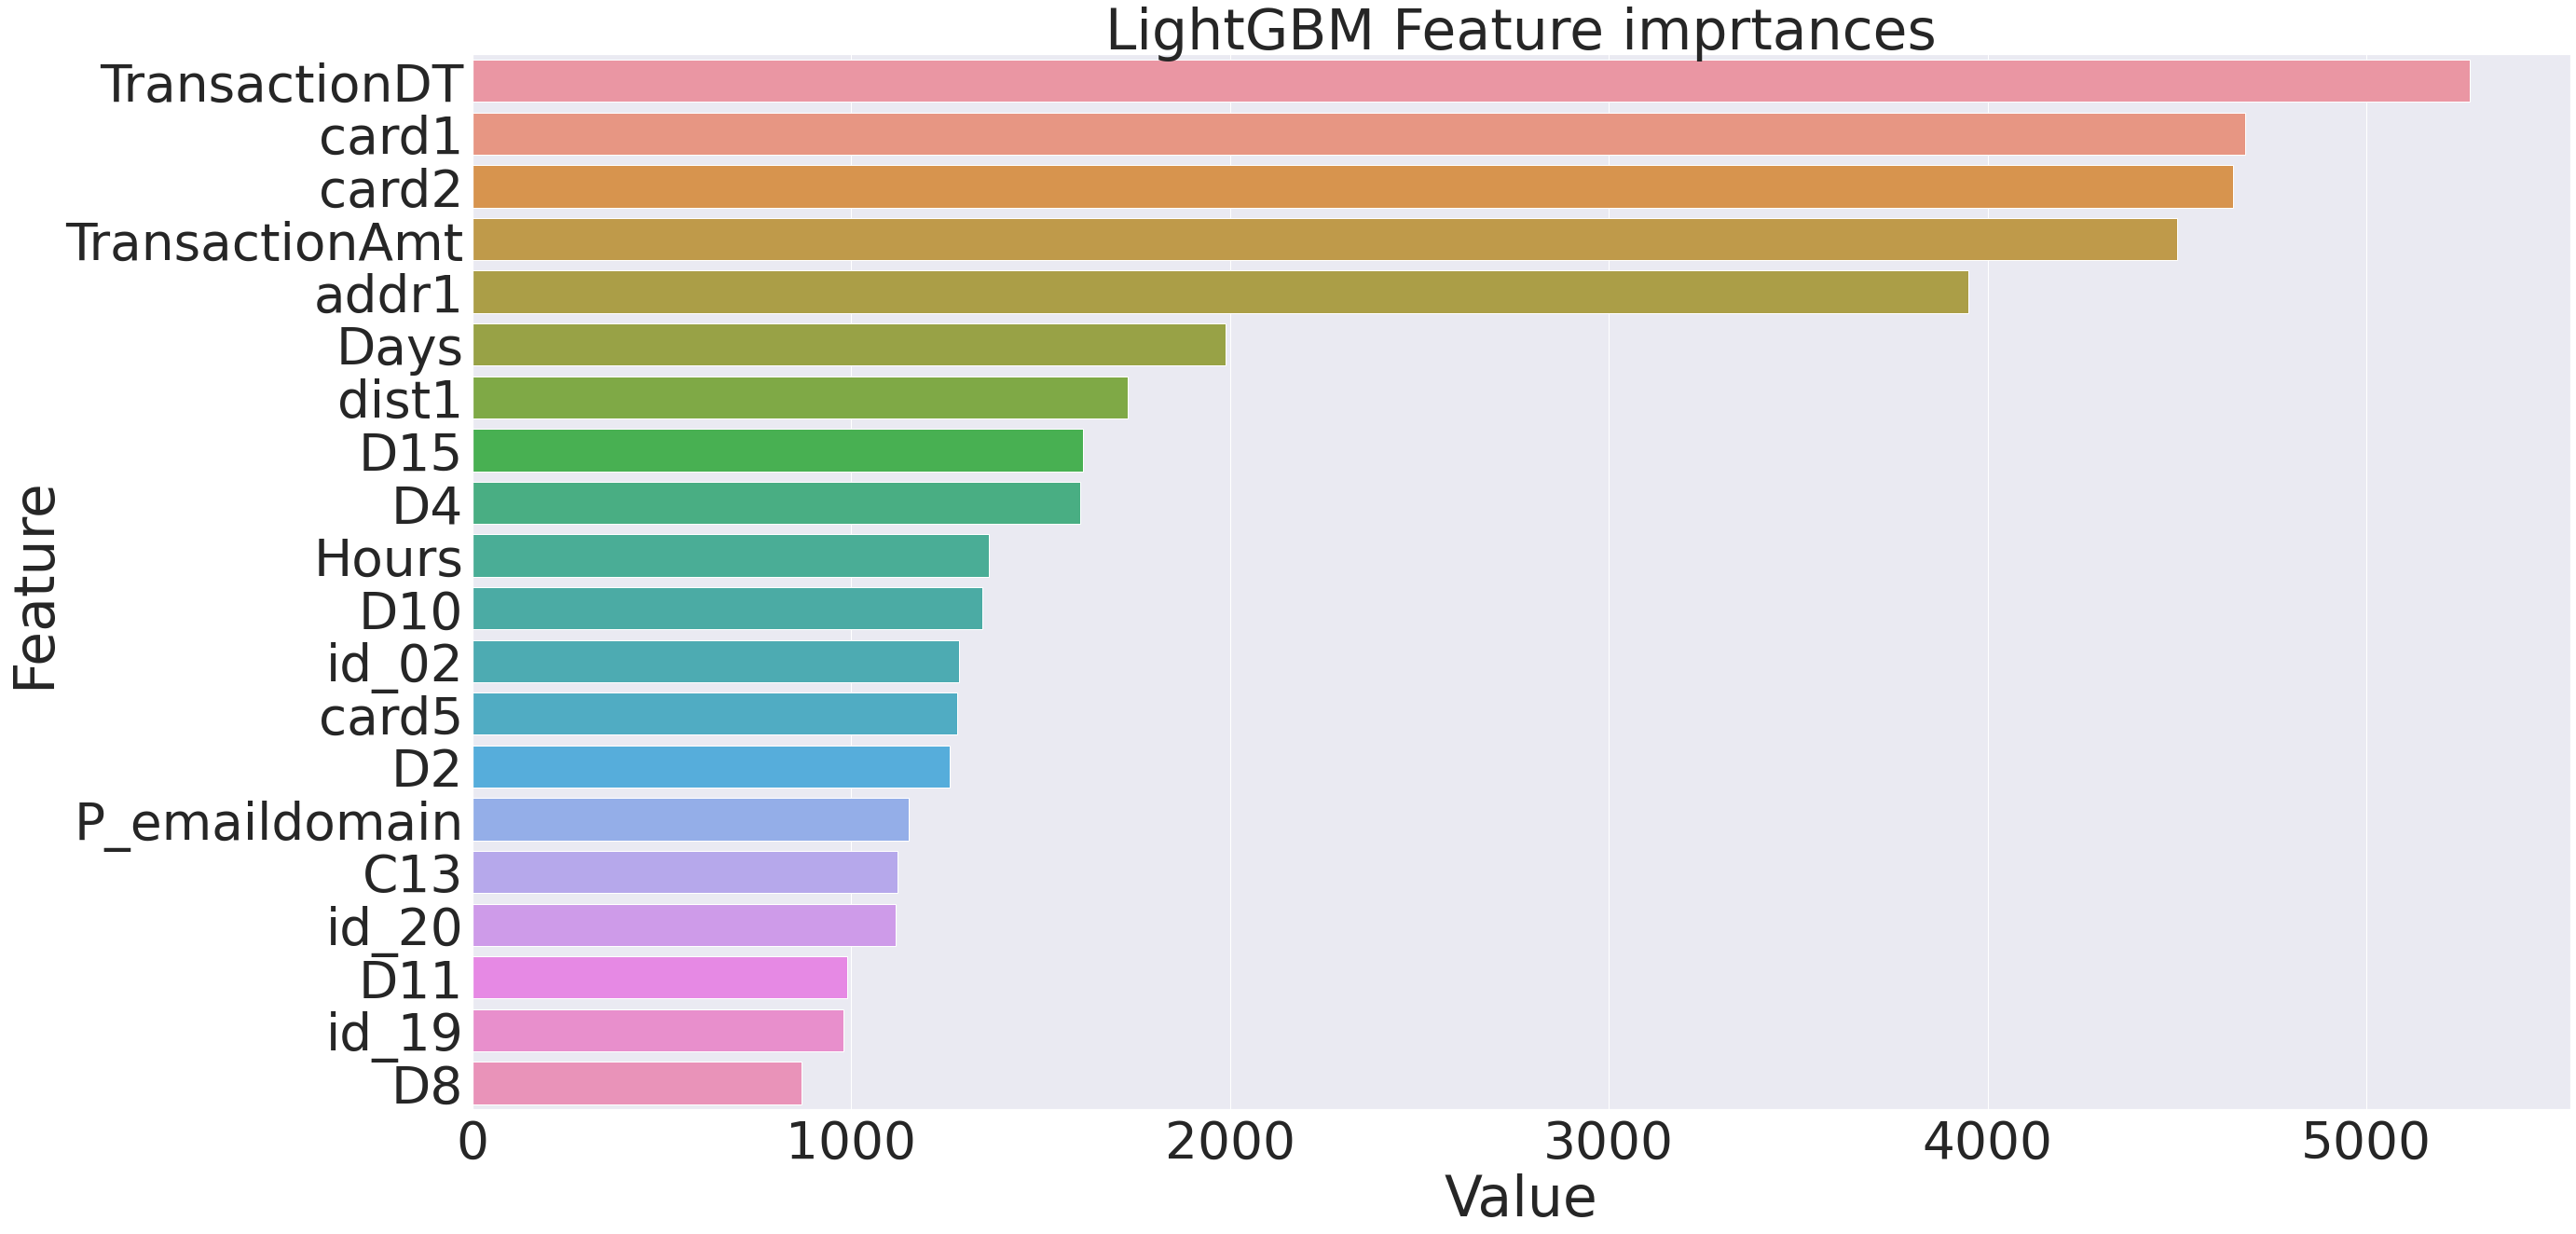

In [79]:
def plotImp(model, X , num = 20):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=(40, 20))
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Feature imprtances')
    plt.tight_layout()
    
    plt.show()
    
plotImp(model, Features_train , num =20)

Summary
- Card1,Card2 TransactionDT and TransactionAmt seem to hold a major importance in the model
- Still scope for Feature Engineering by adjusting the value counts of the categorical variables we would like to hold

- The notebook helped me learn and practice Feature Engineering and Visualization.
- Let me know if there is any further scope of improvement!